# Adverse Events DDIs discovery pipeline

Steps to build the pipeline:
1. Useful functions for the pipeline (mapping, retrieving data from web apis...)
2. Find positive and negative controls for the AE of interest
3. Retrieve adverse event report data for these and a set of control drugs
4. Build the training and testing frequency tables
5. Features reduction to avoid overfitting
6. Drugpair predictions
7. Corroboration using OHDSI data

In [1]:
import csv
import gzip
import tqdm
import json
import heapq
import random
import urllib2

import requests
import itertools

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats
from collections import defaultdict
from biothings_client import get_client

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from urllib2 import Request, urlopen, URLError, build_opener
from json import JSONEncoder

%matplotlib inline

In [2]:
#from import_notebook import *
#sys.meta_path.append(NotebookFinder())
#import OHDSI_API_data_ as ohdsi

## Needed functions

In [3]:
ADVERSE_EVENT_OF_INTEREST = 'hypertension'

# Soon to be replaced by a nsides API call
AE_LIST = ['hypertension', 'hypoglycemia']

In [4]:
# Authentication module
# Instructions at https://documentation.uts.nlm.nih.gov/rest/home.html

def get_tgt(apikey):
    """
    get the tgt corresponding to the apikey
    """
    tgt = requests.post("https://utslogin.nlm.nih.gov/cas/v1/api-key", data = {'apikey':apikey})
    TGT = tgt.content.split()[20]
    TGT = TGT[52:+len(TGT)-1]
    return TGT

def get_ticket(tgt):
    """
    get a ticket corresponding to the tgt
    """
    uri_login = "https://utslogin.nlm.nih.gov/cas/v1/tickets/" + tgt
    ticket = requests.post(uri_login, data = {'service':'http://umlsks.nlm.nih.gov'})
    return ticket.content


In [5]:
def AEtoCUI(aeName):
    "Converts AE name to UMLS CUIs"
    cuis = []
    apikey = "6fd08e99-cb99-48be-937c-bbaa5205fd44"
    
    tgt = get_tgt(apikey)
    ticket = get_ticket(tgt)
    
    query = {'ticket':ticket}
    uri = "https://uts-ws.nlm.nih.gov/rest/search/current?string=" + aeName
    r = requests.get(uri, params = query)
    r.encoding = 'utf-8'
    items  = json.loads(r.text)
    
    jsonData = items["result"]
    for s in jsonData['results']:
        cuis.append(s['ui'])
    return cuis

In [6]:
def nsides_api(service, method, args = None):
    """
    Simple python API to access the NSIDES services and data.
    
    service   string, that can be one of three values: aeolus, sider, or omop
    method    string, for a list of methods see http://nsideseb-env.us-east-1.elasticbeanstalk.com
    args      dictionary, method parameters see http://nsideseb-env.us-east-1.elasticbeanstalk.com
    """
    NSIDES_API_URL = 'http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/'
    
    base_url = NSIDES_API_URL + 'query?service=%s&meta=%s' % (service, method)
    url = base_url
    if not args is None:
        url = base_url + '&' + '&'.join(['%s=%s' % (k,v) for k,v in args.items()])
    print url
    
    response = urllib2.urlopen(url).read()
    data = json.loads(response)
    
    return data

In [7]:
def stitch_api(id):
    """
    Function to access STITCH data
    id : stitch id (string)
    returns drug rxnorm
    """
    STITCH_API_URL = 'http://stitch.embl.de/api/json/'
    request = 'resolve?identifier=%s' %(id)
    
    url = STITCH_API_URL + request
    
    response = urllib2.urlopen(url).read()
    data = json.loads(response)
    
    return data
    
data = stitch_api('CID000041774')
print data[0]['preferredName']

acarbose


In [8]:
def annotator(text, ontologies):
    REST_URL = "http://data.bioontology.org"
    API_KEY = 'b55cf758-dbd3-4959-a9c0-2e6bba5b5d8b'
    url = REST_URL + "/annotator?text=" + urllib2.quote(text) + "&ontologies=" + ','.join(ontologies)
    opener = urllib2.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    
    annotations = json.loads(opener.open(url).read())

    return annotations

def name2rxnorm(drugname):
    """
    map the name of a drug to its rxnorm notation
    """
    annotations = annotator(drugname, ['RXNORM'])
    
    rxnorms = list()
    for annotation in annotations:
        rxnorms.append(annotations[0]['annotatedClass']['@id'].split('/')[-1])
    
    return rxnorms

print name2rxnorm('apraclonidine')

[u'14845']


## Find positive and negative controls

In [9]:
invalid_drugnames = list()
invalid_drugnames.append("human brain natriuretic peptide-32")
invalid_drugnames.append("human glucagon")
invalid_drugnames.append("human insulin")
invalid_drugnames.append("vitamin D2")

In [114]:
def get_controls(AE):
    """
    Get lists of positive and negative controls for a given adverse event.
    AE: string, adverse event of interest
    """
    
    # Get a list of drugs (name) known to have the AE as a side effect using SIDER
    reference_byname_bound = list()
    for cui in AEtoCUI(AE):
        #print cui
        data_bound = nsides_api('sider', 'drugForEffectFreq', {'q': "%s" %cui})
        reference_byname_bound.extend([(r['drug_name'], r['upper_bound']) for r in data_bound['results']])

    reference_byname_bound = sorted(set(reference_byname_bound))
    
    high_freq_drugs = list()
    low_freq_drugs = list()
    
    # To remove noise, we only use drugs with high reporting frequencies
    for (drug, freq) in reference_byname_bound:
        #print drug, freq
        if float(freq) > 0.001:
            high_freq_drugs.append(drug)
        else:
            low_freq_drugs.append(drug)
            
    high_freq_drugs = sorted(set(high_freq_drugs))
    low_freq_drugs = sorted(set(low_freq_drugs))
    #print len(high_freq_drugs)
    
    if len(high_freq_drugs) == 0:
        raise Exception("No available reference standard for cui: %s" % cui)
        return 0
    
    # We map those drugs to their rxnorm
    positives = list()
    negatives = list()
    
    for drugname in tqdm(high_freq_drugs):
        if drugname not in invalid_drugnames:
            rxnorms = name2rxnorm(drugname)
            for rxnorm in rxnorms:
                positives.append(int(rxnorm))

    print "Produced reference with %d positive examples and %d negative examples." % (len(positives), len(negatives))
    
    # We randomly pick 2*len(positives) negative controls from what's available in AEOLUS
    if len(negatives) == 0:
        data = nsides_api('aeolus', 'ingredientList')
    
        all_rxnorms = [r['concept_code'] for r in data['results']]
        available_negatives = (set(all_rxnorms) - set(positives))
    
        negatives = random.sample(available_negatives, 2*len(positives))

    print "Randomly selected %d negative examples from available drugs." % len(negatives)
    
    return positives, negatives

In [115]:
positives, negatives = get_controls('diabete')

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=sider&meta=drugForEffect&q=C0011849
http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=sider&meta=drugForEffectFreq&q=C0011849
http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=sider&meta=drugForEffect&q=C0011848
http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=sider&meta=drugForEffectFreq&q=C0011848
http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=sider&meta=drugForEffect&q=C0011854
http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=sider&meta=drugForEffectFreq&q=C0011854
http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=sider&meta=drugForEffect&q=C0011859
http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=sider&meta=drugForEffectFreq&q=C0011859
http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=sider&meta=drugForEffect&q=C0011860
http://nside

  0%|          | 0/17 [00:00<?, ?it/s]

17


100%|██████████| 17/17 [00:15<00:00,  1.22s/it]


Produced reference with 17 positive examples and 0 negative examples.
http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=ingredientList
Randomly selected 34 negative examples from available drugs.


##  Retrieve adverse event report data for these and a set of control drugs.

In [14]:
# concept = OMOP concept id
data = nsides_api('aeolus', 'ingredientList')

concept2name = dict()
all_drugs = list()
drug_mapping = dict()
concept2rxnorm = dict()
rxnorm2concept = dict()

for r in data['results']:
    concept2name[r['concept_id']] = r['concept_name']
    all_drugs.append(r['concept_id'])
    drug_mapping[r['concept_code']] = r['concept_id']
    concept2rxnorm[r['concept_id']] = r['concept_code']
    rxnorm2concept[r['concept_code']] = r['concept_id']

#print drug_mapping.items()
#print concept2name
print data['results'][0]
print len(all_drugs)
#print concept2rxnorm[501343]
print rxnorm2concept[5640]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=ingredientList
{u'valid_end_date': u'2099-12-31', u'concept_class_id': u'Ingredient', u'valid_start_date': u'1970-01-01', u'vocabulary_id': u'RxNorm', u'concept_name': u'hepatitis B immune globulin', u'invalid_reason': u'', u'standard_concept_id': 501343, u'standard_concept': u'S', u'concept_code': 26744, u'domain_id': u'Drug', u'concept_id': 501343}
3526
1177480


In [15]:
#query?service=aeolus&meta=reactionListMedDRA
data = nsides_api('aeolus', 'reactionListMedDRA')

# List of all AEs reported in FAERS
all_outcomes = list() 

for r in data['results']:
    all_outcomes.append(r['outcome_concept_id'])

print len(all_outcomes)
print data['results'][0]
print all_outcomes[0]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=reactionListMedDRA
7540
{u'valid_end_date': u'2099-12-31', u'concept_class_id': u'LLT', u'outcome_concept_id': 36718526, u'valid_start_date': u'1970-01-01', u'vocabulary_id': u'MedDRA', u'concept_name': u'Convulsion', u'invalid_reason': u'', u'snomed_outcome_concept_id': 377091, u'standard_concept': u'C', u'concept_code': 10010904, u'domain_id': u'Condition', u'concept_id': 36718526}
36718526


In [16]:
#query?service=aeolus&meta=drugpairReactionListMedDRA
data = nsides_api('aeolus', 'drugpairReactionListMedDRA')
#List of all AEs reported as drugpairs outcome in FAERS
all_pairoutcomes = list()
all_conceptnames = list()
for r in data['results']:
    all_pairoutcomes.append(r['outcome_concept_id'])
    all_conceptnames.append(r['concept_name'])

print len(all_pairoutcomes)
print all_pairoutcomes[0]
print data['results'][0]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionListMedDRA
199
37622529
{u'valid_end_date': u'2099-12-31', u'concept_class_id': u'PT', u'outcome_concept_id': 37622529, u'valid_start_date': u'1970-01-01', u'vocabulary_id': u'MedDRA', u'concept_name': u'Hypertension', u'invalid_reason': u'', u'standard_concept': u'C', u'concept_code': 10020772, u'domain_id': u'Condition', u'concept_id': 37622529}


In [17]:
#query?service=aeolus&meta=drugpairList
data = nsides_api('aeolus', 'drugpairList')

all_drugpairs = list()

for r in data['results']:
    all_drugpairs.append((r['drug1_concept_id'], r['drug2_concept_id']))

print len(all_drugpairs)
print all_drugpairs[0]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairList
39800
(19111620, 19122121)


In [18]:
#query?service=aeolus&meta=drugReactionCounts&q=0
data = nsides_api('aeolus', 'drugReactionCounts', {'q':0})

aeolus_drugReactionCounts = dict()
aeolus_drugReactionCounts['results'] = list()

for start in tqdm(range(0, data[0]['nrows'][0], 10000)):    
    aeolus_drugReactionCounts['results'].extend(data[0]['result'])    
    start = len(aeolus_drugReactionCounts['results'])
    data = nsides_api('aeolus', 'drugReactionCounts', {'q': start})

print len(aeolus_drugReactionCounts['results'])
print aeolus_drugReactionCounts['results'][0]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=0


  0%|          | 0/64 [00:00<?, ?it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=10000


  2%|▏         | 1/64 [00:02<02:49,  2.69s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=20000


  3%|▎         | 2/64 [00:05<02:46,  2.69s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=30000


  5%|▍         | 3/64 [00:11<03:46,  3.71s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=40000


  6%|▋         | 4/64 [00:14<03:22,  3.37s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=50000


  8%|▊         | 5/64 [00:16<03:05,  3.14s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=60000


  9%|▉         | 6/64 [00:19<02:52,  2.97s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=70000


 11%|█         | 7/64 [00:21<02:43,  2.86s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=80000


 12%|█▎        | 8/64 [00:24<02:36,  2.80s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=90000


 14%|█▍        | 9/64 [00:27<02:31,  2.75s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=100000


 16%|█▌        | 10/64 [00:29<02:26,  2.71s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=110000


 17%|█▋        | 11/64 [00:32<02:24,  2.72s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=120000


 19%|█▉        | 12/64 [00:35<02:21,  2.72s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=130000


 20%|██        | 13/64 [00:37<02:18,  2.71s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=140000


 22%|██▏       | 14/64 [00:40<02:17,  2.75s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=150000


 23%|██▎       | 15/64 [00:43<02:14,  2.74s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=160000


 25%|██▌       | 16/64 [00:46<02:11,  2.73s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=170000


 27%|██▋       | 17/64 [00:49<02:15,  2.87s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=180000


 28%|██▊       | 18/64 [00:55<02:59,  3.90s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=190000


 30%|██▉       | 19/64 [00:58<02:41,  3.58s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=200000


 31%|███▏      | 20/64 [01:01<02:27,  3.36s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=210000


 33%|███▎      | 21/64 [01:04<02:18,  3.23s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=220000


 34%|███▍      | 22/64 [01:07<02:11,  3.14s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=230000


 36%|███▌      | 23/64 [01:10<02:05,  3.06s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=240000


 38%|███▊      | 24/64 [01:12<02:00,  3.01s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=250000


 39%|███▉      | 25/64 [01:15<01:56,  2.98s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=260000


 41%|████      | 26/64 [01:18<01:54,  3.00s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=270000


 42%|████▏     | 27/64 [01:21<01:51,  3.01s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=280000


 44%|████▍     | 28/64 [01:25<01:49,  3.03s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=290000


 45%|████▌     | 29/64 [01:28<01:45,  3.03s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=300000


 47%|████▋     | 30/64 [01:31<01:43,  3.04s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=310000


 48%|████▊     | 31/64 [01:34<01:41,  3.09s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=320000


 50%|█████     | 32/64 [01:37<01:37,  3.06s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=330000


 52%|█████▏    | 33/64 [01:40<01:35,  3.08s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=340000


 53%|█████▎    | 34/64 [01:43<01:32,  3.08s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=350000


 55%|█████▍    | 35/64 [01:46<01:29,  3.10s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=360000


 56%|█████▋    | 36/64 [01:49<01:27,  3.13s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=370000


 58%|█████▊    | 37/64 [01:53<01:26,  3.21s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=380000


 59%|█████▉    | 38/64 [01:56<01:23,  3.22s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=390000


 61%|██████    | 39/64 [01:59<01:20,  3.23s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=400000


 62%|██████▎   | 40/64 [02:03<01:18,  3.26s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=410000


 64%|██████▍   | 41/64 [02:06<01:15,  3.27s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=420000


 66%|██████▌   | 42/64 [02:09<01:11,  3.25s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=430000


 67%|██████▋   | 43/64 [02:13<01:09,  3.33s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=440000


 69%|██████▉   | 44/64 [02:16<01:06,  3.32s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=450000


 70%|███████   | 45/64 [02:19<01:03,  3.32s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=460000


 72%|███████▏  | 46/64 [02:23<01:00,  3.35s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=470000


 73%|███████▎  | 47/64 [02:26<00:57,  3.36s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=480000


 75%|███████▌  | 48/64 [02:29<00:53,  3.34s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=490000


 77%|███████▋  | 49/64 [02:33<00:50,  3.40s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=500000


 78%|███████▊  | 50/64 [02:36<00:47,  3.37s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=510000


 80%|███████▉  | 51/64 [02:40<00:44,  3.39s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=520000


 81%|████████▏ | 52/64 [02:43<00:40,  3.41s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=530000


 83%|████████▎ | 53/64 [02:47<00:37,  3.45s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=540000


 84%|████████▍ | 54/64 [02:50<00:35,  3.51s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=550000


 86%|████████▌ | 55/64 [02:54<00:31,  3.55s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=560000


 88%|████████▊ | 56/64 [02:57<00:28,  3.53s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=570000


 89%|████████▉ | 57/64 [03:01<00:24,  3.57s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=580000


 91%|█████████ | 58/64 [03:05<00:22,  3.70s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=590000


 92%|█████████▏| 59/64 [03:09<00:18,  3.72s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=600000


 94%|█████████▍| 60/64 [03:12<00:14,  3.71s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=610000


 95%|█████████▌| 61/64 [03:16<00:11,  3.71s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=620000


 97%|█████████▋| 62/64 [03:20<00:07,  3.71s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=630000


 98%|█████████▊| 63/64 [03:22<00:03,  3.37s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugReactionCounts&q=631743


100%|██████████| 64/64 [03:25<00:00,  3.06s/it]

631743
{u'nreports': 11, u'outcome_concept_id': 35104067, u'drug_concept_id': 904453, u'ndrugreports': 448710}


In [19]:
unrecognized_id = list()
unrecognized_id.append('CID011953896')
unrecognized_id.append('CID000003706')
unrecognized_id.append('CID000002550')
unrecognized_id.append('CID000031371')
unrecognized_id.append('CID000054688')
unrecognized_id.append('CID000000653')
unrecognized_id.append('CID000009908')
unrecognized_id.append('CID000005257')
unrecognized_id.append('CID000006691')
unrecognized_id.append('CID000002177')
unrecognized_id.append('CID000002949')
unrecognized_id.append('CID000002909')
unrecognized_id.append('CID000005267')
unrecognized_id.append('CID000028112')
unrecognized_id.append('CID000001451')
unrecognized_id.append('CID000016213')
unrecognized_id.append('CID000003075')
unrecognized_id.append('CID005311048')
unrecognized_id.append('CID000003929')
unrecognized_id.append('CID000004691')
unrecognized_id.append('CID000003962')
unrecognized_id.append('CID005361912')
unrecognized_id.append('CID000005064')
unrecognized_id.append('CID006420046')
unrecognized_id.append('CID000003143')
unrecognized_id.append('CID000004048')
unrecognized_id.append('CID000003222')
unrecognized_id.append('CID000150310')
unrecognized_id.append('CID000005372')
unrecognized_id.append('CID000062924')
unrecognized_id.append('CID000443871')
unrecognized_id.append('CID006419754')
unrecognized_id.append('CID000004547')
unrecognized_id.append('CID000065027')
unrecognized_id.append('CID000004259')
unrecognized_id.append('CID011953892')
unrecognized_id.append('CID000004724')
unrecognized_id.append('CID000002769')
unrecognized_id.append('CID000005412')

print len(unrecognized_id)

39


In [20]:
#query?service=va&meta=get_ddi_alerts

# Retrieve data from the Veteran Affairs Hospital (Stitch ids)
# We map those drugs to their rxnorm

data = nsides_api('va', 'get_ddi_alerts')
print data
#print len(data['results'])

va_ddi_alerts = list()

for r in tqdm(data['results']):
    
    #print r
    
    if (r['drug_1'] in unrecognized_id) or (r['drug_2'] in unrecognized_id):
        continue
    
    stitch_data1 = stitch_api(r['drug_1'])
    stitch_data2 = stitch_api(r['drug_2'])

    drugs1 = name2rxnorm(stitch_data1[0]['preferredName'])
    drugs2 = name2rxnorm(stitch_data2[0]['preferredName'])
    
    for drug1 in drugs1:
        drug1 = (int(drug1))
    for drug2 in drugs2:
        drug2 = (int(drug2))
        
    va_ddi_alerts.append((drug1, drug2))

print len(va_ddi_alerts)
print va_ddi_alerts[0]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=va&meta=get_ddi_alerts
{u'': u''}


KeyError: 'results'

In [43]:
key_errors = list()
key_errors.append(17941)
key_errors.append(7930)
key_errors.append(357280)
key_errors.append(218863)
key_errors.append(353062)

In [20]:
# We map drugpairs from rxnorm to their OMOP id
va_omop_ddi = list()

for drugpair in va_ddi_alerts:
    #print drugpair
    if drugpair[0] in key_errors:
        continue
    if drugpair[1] in key_errors:
        continue
    va_omop_ddi.append((rxnorm2concept[drugpair[0]],rxnorm2concept[drugpair[1]]))

print len(va_ddi_alerts)
print len(va_omop_ddi)
print va_omop_ddi[0]

641
574
(1529331, 1789276)


In [21]:
#LOINC to OMOP
#/api/v1/query?service=omop&meta=get_omop_from_loinc&q=28377-0
data = nsides_api('omop', 'get_omop_from_loinc', {'q':'28377-0'})
print len(data)
print data

1
{u'results': [{u'concept_id': u'3000000'}]}


## Build the training table for single drugs

In [40]:
def make_lsd_training_table(pos_drugs = None, neg_drugs = None):

    # we map positive and negative drugs from their concept_code to their concept_id
    pos_drugs_mapped = list()
    for pos_drug in pos_drugs:
        pos_drugs_mapped.append(drug_mapping[pos_drug])
        
    neg_drugs_mapped = list()
    for neg_drug in neg_drugs:
        neg_drugs_mapped.append(drug_mapping[neg_drug])
        
    outcomes = np.concatenate((np.ones(len(pos_drugs),np.bool), np.zeros(len(neg_drugs),np.bool)))
    
    training_drugs = pos_drugs_mapped + neg_drugs_mapped
    
    # build the adverse events frequency table
    ae_frequencies_training = np.zeros((len(pos_drugs)+len(neg_drugs),len(all_pairoutcomes)))
    
    for r in aeolus_drugReactionCounts['results']:
        if not r['drug_concept_id'] in training_drugs:
            continue
        if not r['outcome_concept_id'] in all_pairoutcomes:
            continue
        
        
        i = training_drugs.index(r['drug_concept_id'])
        j = all_pairoutcomes.index(r['outcome_concept_id'])
        
        frequency = float(r['nreports'])/float(r['ndrugreports'])
        
        ae_frequencies_training[i,j] = frequency
                    
    return ae_frequencies_training, outcomes

In [116]:
# we only keep drugs that can be mapped
pos_controls = [p for p in positives if p in drug_mapping]
neg_controls = [n for n in negatives if n in drug_mapping]

print len(pos_controls)
print len(neg_controls)

17
34


In [117]:
X,y = make_lsd_training_table(pos_controls, neg_controls)

print X.shape
print y.shape

print y.sum()

(51, 199)
(51,)
17


### Same process for drugpairs

In [43]:
#query?service=aeolus&meta=drugpairReactionCounts&q=0
data = nsides_api('aeolus', 'drugpairReactionCounts', {'q':0})

aeolus_drugpairReactionCounts = dict()
aeolus_drugpairReactionCounts['results'] = list()

for start in tqdm(range(0, data[0]['nrows'][0], 10000)):    
    aeolus_drugpairReactionCounts['results'].extend(data[0]['results'])    
    start = len(aeolus_drugpairReactionCounts['results'])
    data = nsides_api('aeolus', 'drugpairReactionCounts', {'q': start})

len(aeolus_drugpairReactionCounts['results'])

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=0


  0%|          | 0/793 [00:00<?, ?it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=10000


  0%|          | 1/793 [00:01<19:16,  1.46s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=20000


  0%|          | 2/793 [00:02<19:31,  1.48s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=30000


  0%|          | 3/793 [00:04<19:42,  1.50s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=40000


  1%|          | 4/793 [00:06<20:22,  1.55s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=50000


  1%|          | 5/793 [00:07<20:38,  1.57s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=60000


  1%|          | 6/793 [00:09<20:12,  1.54s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=70000


  1%|          | 7/793 [00:10<19:42,  1.50s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=80000


  1%|          | 8/793 [00:12<18:58,  1.45s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=90000


  1%|          | 9/793 [00:13<19:52,  1.52s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=100000


  1%|▏         | 10/793 [00:15<19:35,  1.50s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=110000


  1%|▏         | 11/793 [00:16<19:42,  1.51s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=120000


  2%|▏         | 12/793 [00:18<19:16,  1.48s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=130000


  2%|▏         | 13/793 [00:19<19:27,  1.50s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=140000


  2%|▏         | 14/793 [00:21<20:22,  1.57s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=150000


  2%|▏         | 15/793 [00:22<20:11,  1.56s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=160000


  2%|▏         | 16/793 [00:24<19:48,  1.53s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=170000


  2%|▏         | 17/793 [00:26<20:07,  1.56s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=180000


  2%|▏         | 18/793 [00:27<19:49,  1.53s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=190000


  2%|▏         | 19/793 [00:29<20:36,  1.60s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=200000


  3%|▎         | 20/793 [00:30<19:51,  1.54s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=210000


  3%|▎         | 21/793 [00:32<21:03,  1.64s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=220000


  3%|▎         | 22/793 [00:34<20:54,  1.63s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=230000


  3%|▎         | 23/793 [00:35<21:21,  1.66s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=240000


  3%|▎         | 24/793 [00:37<21:32,  1.68s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=250000


  3%|▎         | 25/793 [00:39<21:23,  1.67s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=260000


  3%|▎         | 26/793 [00:40<21:01,  1.64s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=270000


  3%|▎         | 27/793 [00:42<20:53,  1.64s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=280000


  4%|▎         | 28/793 [00:44<21:03,  1.65s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=290000


  4%|▎         | 29/793 [00:45<20:48,  1.63s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=300000


  4%|▍         | 30/793 [00:47<21:03,  1.66s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=310000


  4%|▍         | 31/793 [00:49<22:20,  1.76s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=320000


  4%|▍         | 32/793 [00:50<21:01,  1.66s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=330000


  4%|▍         | 33/793 [00:52<20:48,  1.64s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=340000


  4%|▍         | 34/793 [00:54<21:20,  1.69s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=350000


  4%|▍         | 35/793 [00:56<23:00,  1.82s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=360000


  5%|▍         | 36/793 [00:58<22:54,  1.82s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=370000


  5%|▍         | 37/793 [00:59<21:49,  1.73s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=380000


  5%|▍         | 38/793 [01:01<21:02,  1.67s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=390000


  5%|▍         | 39/793 [01:02<20:51,  1.66s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=400000


  5%|▌         | 40/793 [01:04<20:14,  1.61s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=410000


  5%|▌         | 41/793 [01:06<21:01,  1.68s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=420000


  5%|▌         | 42/793 [01:07<20:34,  1.64s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=430000


  5%|▌         | 43/793 [01:09<20:20,  1.63s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=440000


  6%|▌         | 44/793 [01:11<20:29,  1.64s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=450000


  6%|▌         | 45/793 [01:12<20:21,  1.63s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=460000


  6%|▌         | 46/793 [01:14<20:34,  1.65s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=470000


  6%|▌         | 47/793 [01:16<20:51,  1.68s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=480000


  6%|▌         | 48/793 [01:17<21:11,  1.71s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=490000


  6%|▌         | 49/793 [01:19<21:16,  1.72s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=500000


  6%|▋         | 50/793 [01:21<21:13,  1.71s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=510000


  6%|▋         | 51/793 [01:22<20:54,  1.69s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=520000


  7%|▋         | 52/793 [01:24<20:43,  1.68s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=530000


  7%|▋         | 53/793 [01:26<20:12,  1.64s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=540000


  7%|▋         | 54/793 [01:27<20:08,  1.64s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=550000


  7%|▋         | 55/793 [01:29<20:36,  1.67s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=560000


  7%|▋         | 56/793 [01:31<20:06,  1.64s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=570000


  7%|▋         | 57/793 [01:32<19:59,  1.63s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=580000


  7%|▋         | 58/793 [01:34<19:46,  1.61s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=590000


  7%|▋         | 59/793 [01:35<19:57,  1.63s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=600000


  8%|▊         | 60/793 [01:37<20:18,  1.66s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=610000


  8%|▊         | 61/793 [01:39<20:01,  1.64s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=620000


  8%|▊         | 62/793 [01:40<19:46,  1.62s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=630000


  8%|▊         | 63/793 [01:42<19:53,  1.63s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=640000


  8%|▊         | 64/793 [01:43<19:20,  1.59s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=650000


  8%|▊         | 65/793 [01:45<19:28,  1.60s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=660000


  8%|▊         | 66/793 [01:47<19:08,  1.58s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=670000


  8%|▊         | 67/793 [01:48<20:04,  1.66s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=680000


  9%|▊         | 68/793 [01:50<19:26,  1.61s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=690000


  9%|▊         | 69/793 [01:52<19:19,  1.60s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=700000


  9%|▉         | 70/793 [01:53<19:15,  1.60s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=710000


  9%|▉         | 71/793 [01:55<19:08,  1.59s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=720000


  9%|▉         | 72/793 [01:56<19:19,  1.61s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=730000


  9%|▉         | 73/793 [01:58<19:19,  1.61s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=740000


  9%|▉         | 74/793 [02:00<19:15,  1.61s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=750000


  9%|▉         | 75/793 [02:01<19:22,  1.62s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=760000


 10%|▉         | 76/793 [02:03<19:04,  1.60s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=770000


 10%|▉         | 77/793 [02:05<20:11,  1.69s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=780000


 10%|▉         | 78/793 [02:06<20:15,  1.70s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=790000


 10%|▉         | 79/793 [02:08<20:02,  1.68s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=800000


 10%|█         | 80/793 [02:10<19:34,  1.65s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=810000


 10%|█         | 81/793 [02:11<19:31,  1.65s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=820000


 10%|█         | 82/793 [02:13<19:50,  1.67s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=830000


 10%|█         | 83/793 [02:15<19:32,  1.65s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=840000


 11%|█         | 84/793 [02:16<20:06,  1.70s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=850000


 11%|█         | 85/793 [02:18<19:48,  1.68s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=860000


 11%|█         | 86/793 [02:20<19:35,  1.66s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=870000


 11%|█         | 87/793 [02:21<19:48,  1.68s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=880000


 11%|█         | 88/793 [02:23<20:23,  1.73s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=890000


 11%|█         | 89/793 [02:25<19:52,  1.69s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=900000


 11%|█▏        | 90/793 [02:27<21:19,  1.82s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=910000


 11%|█▏        | 91/793 [02:29<21:50,  1.87s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=920000


 12%|█▏        | 92/793 [02:31<21:28,  1.84s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=930000


 12%|█▏        | 93/793 [02:33<22:30,  1.93s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=940000


 12%|█▏        | 94/793 [02:35<22:04,  1.89s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=950000


 12%|█▏        | 95/793 [02:37<21:50,  1.88s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=960000


 12%|█▏        | 96/793 [02:38<21:53,  1.88s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=970000


 12%|█▏        | 97/793 [02:40<22:03,  1.90s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=980000


 12%|█▏        | 98/793 [02:42<21:20,  1.84s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=990000


 12%|█▏        | 99/793 [02:44<21:09,  1.83s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1000000


 13%|█▎        | 100/793 [02:46<21:38,  1.87s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1010000


 13%|█▎        | 101/793 [02:49<24:39,  2.14s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1020000


 13%|█▎        | 102/793 [02:50<22:59,  2.00s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1030000


 13%|█▎        | 103/793 [02:52<23:16,  2.02s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1040000


 13%|█▎        | 104/793 [02:55<23:51,  2.08s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1050000


 13%|█▎        | 105/793 [02:56<22:53,  2.00s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1060000


 13%|█▎        | 106/793 [02:58<21:45,  1.90s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1070000


 13%|█▎        | 107/793 [03:00<20:59,  1.84s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1080000


 14%|█▎        | 108/793 [03:01<20:24,  1.79s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1090000


 14%|█▎        | 109/793 [03:03<20:36,  1.81s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1100000


 14%|█▍        | 110/793 [03:05<20:34,  1.81s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1110000


 14%|█▍        | 111/793 [03:07<20:55,  1.84s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1120000


 14%|█▍        | 112/793 [03:09<21:43,  1.91s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1130000


 14%|█▍        | 113/793 [03:11<21:01,  1.86s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1140000


 14%|█▍        | 114/793 [03:13<20:33,  1.82s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1150000


 15%|█▍        | 115/793 [03:14<21:00,  1.86s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1160000


 15%|█▍        | 116/793 [03:16<20:29,  1.82s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1170000


 15%|█▍        | 117/793 [03:18<20:36,  1.83s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1180000


 15%|█▍        | 118/793 [03:20<20:10,  1.79s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1190000


 15%|█▌        | 119/793 [03:22<20:22,  1.81s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1200000


 15%|█▌        | 120/793 [03:24<20:43,  1.85s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1210000


 15%|█▌        | 121/793 [03:25<20:34,  1.84s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1220000


 15%|█▌        | 122/793 [03:27<20:31,  1.84s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1230000


 16%|█▌        | 123/793 [03:29<20:33,  1.84s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1240000


 16%|█▌        | 124/793 [03:31<20:42,  1.86s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1250000


 16%|█▌        | 125/793 [03:33<20:44,  1.86s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1260000


 16%|█▌        | 126/793 [03:35<21:15,  1.91s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1270000


 16%|█▌        | 127/793 [03:37<22:00,  1.98s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1280000


 16%|█▌        | 128/793 [03:39<21:38,  1.95s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1290000


 16%|█▋        | 129/793 [03:41<21:24,  1.93s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1300000


 16%|█▋        | 130/793 [03:43<21:09,  1.91s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1310000


 17%|█▋        | 131/793 [03:44<17:56,  1.63s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 17%|█▋        | 132/793 [03:44<14:16,  1.30s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 17%|█▋        | 133/793 [03:45<11:42,  1.06s/it]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 17%|█▋        | 134/793 [03:45<09:51,  1.11it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 17%|█▋        | 135/793 [03:46<08:42,  1.26it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 17%|█▋        | 136/793 [03:46<07:43,  1.42it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 17%|█▋        | 137/793 [03:47<07:12,  1.52it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 17%|█▋        | 138/793 [03:47<06:58,  1.57it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 18%|█▊        | 139/793 [03:48<06:30,  1.67it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 18%|█▊        | 140/793 [03:48<06:14,  1.74it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 18%|█▊        | 141/793 [03:49<06:06,  1.78it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 18%|█▊        | 142/793 [03:49<06:03,  1.79it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 18%|█▊        | 143/793 [03:50<05:56,  1.82it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 18%|█▊        | 144/793 [03:50<05:50,  1.85it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 18%|█▊        | 145/793 [03:51<05:48,  1.86it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 18%|█▊        | 146/793 [03:52<05:42,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 19%|█▊        | 147/793 [03:52<05:34,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 19%|█▊        | 148/793 [03:53<05:33,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 19%|█▉        | 149/793 [03:53<05:30,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 19%|█▉        | 150/793 [03:54<05:27,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 19%|█▉        | 151/793 [03:54<05:30,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 19%|█▉        | 152/793 [03:55<05:30,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 19%|█▉        | 153/793 [03:55<05:27,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 19%|█▉        | 154/793 [03:56<05:25,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 20%|█▉        | 155/793 [03:56<05:24,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 20%|█▉        | 156/793 [03:57<05:26,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 20%|█▉        | 157/793 [03:57<05:27,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 20%|█▉        | 158/793 [03:58<05:27,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 20%|██        | 159/793 [03:58<05:30,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 20%|██        | 160/793 [03:59<05:31,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 20%|██        | 161/793 [03:59<05:35,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 20%|██        | 162/793 [04:00<05:31,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 21%|██        | 163/793 [04:00<05:28,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 21%|██        | 164/793 [04:01<05:25,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 21%|██        | 165/793 [04:01<05:23,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 21%|██        | 166/793 [04:02<05:24,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 21%|██        | 167/793 [04:02<05:23,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 21%|██        | 168/793 [04:03<05:30,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 21%|██▏       | 169/793 [04:03<05:28,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 21%|██▏       | 170/793 [04:04<05:26,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 22%|██▏       | 171/793 [04:04<05:33,  1.86it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 22%|██▏       | 172/793 [04:05<05:28,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 22%|██▏       | 173/793 [04:06<05:26,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 22%|██▏       | 174/793 [04:06<05:23,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 22%|██▏       | 175/793 [04:07<05:21,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 22%|██▏       | 176/793 [04:07<05:22,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 22%|██▏       | 177/793 [04:08<05:20,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 22%|██▏       | 178/793 [04:08<05:23,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 23%|██▎       | 179/793 [04:09<05:19,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 23%|██▎       | 180/793 [04:09<05:18,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 23%|██▎       | 181/793 [04:10<05:14,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 23%|██▎       | 182/793 [04:10<05:12,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 23%|██▎       | 183/793 [04:11<05:13,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 23%|██▎       | 184/793 [04:11<05:11,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 23%|██▎       | 185/793 [04:12<05:12,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 23%|██▎       | 186/793 [04:12<05:11,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 24%|██▎       | 187/793 [04:13<05:09,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 24%|██▎       | 188/793 [04:13<05:07,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 24%|██▍       | 189/793 [04:14<05:05,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 24%|██▍       | 190/793 [04:14<05:12,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 24%|██▍       | 191/793 [04:15<05:11,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 24%|██▍       | 192/793 [04:15<05:13,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 24%|██▍       | 193/793 [04:16<05:12,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 24%|██▍       | 194/793 [04:16<05:07,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 25%|██▍       | 195/793 [04:17<05:09,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 25%|██▍       | 196/793 [04:17<05:22,  1.85it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 25%|██▍       | 197/793 [04:18<05:17,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 25%|██▍       | 198/793 [04:19<05:15,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 25%|██▌       | 199/793 [04:19<05:13,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 25%|██▌       | 200/793 [04:20<05:11,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 25%|██▌       | 201/793 [04:20<05:06,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 25%|██▌       | 202/793 [04:21<05:02,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 26%|██▌       | 203/793 [04:21<05:01,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 26%|██▌       | 204/793 [04:22<04:58,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 26%|██▌       | 205/793 [04:22<04:57,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 26%|██▌       | 206/793 [04:23<04:56,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 26%|██▌       | 207/793 [04:23<04:57,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 26%|██▌       | 208/793 [04:24<05:03,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 26%|██▋       | 209/793 [04:24<05:04,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 26%|██▋       | 210/793 [04:25<04:59,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 27%|██▋       | 211/793 [04:25<04:55,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 27%|██▋       | 212/793 [04:26<04:52,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 27%|██▋       | 213/793 [04:26<04:52,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 27%|██▋       | 214/793 [04:27<04:50,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 27%|██▋       | 215/793 [04:27<04:53,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 27%|██▋       | 216/793 [04:28<04:51,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 27%|██▋       | 217/793 [04:28<04:50,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 27%|██▋       | 218/793 [04:29<04:49,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 28%|██▊       | 219/793 [04:29<04:50,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 28%|██▊       | 220/793 [04:30<04:48,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 28%|██▊       | 221/793 [04:30<04:47,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 28%|██▊       | 222/793 [04:31<04:48,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 28%|██▊       | 223/793 [04:31<04:53,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 28%|██▊       | 224/793 [04:32<04:54,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 28%|██▊       | 225/793 [04:32<04:52,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 28%|██▊       | 226/793 [04:33<04:54,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 29%|██▊       | 227/793 [04:33<04:52,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 29%|██▉       | 228/793 [04:34<04:48,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 29%|██▉       | 229/793 [04:34<04:51,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 29%|██▉       | 230/793 [04:35<04:47,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 29%|██▉       | 231/793 [04:35<04:47,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 29%|██▉       | 232/793 [04:36<04:44,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 29%|██▉       | 233/793 [04:36<04:44,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 30%|██▉       | 234/793 [04:37<04:53,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 30%|██▉       | 235/793 [04:37<04:53,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 30%|██▉       | 236/793 [04:38<04:47,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 30%|██▉       | 237/793 [04:38<04:44,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 30%|███       | 238/793 [04:39<04:42,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 30%|███       | 239/793 [04:39<04:45,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 30%|███       | 240/793 [04:40<04:45,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 30%|███       | 241/793 [04:40<04:43,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 31%|███       | 242/793 [04:41<04:40,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 31%|███       | 243/793 [04:41<04:38,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 31%|███       | 244/793 [04:42<04:36,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 31%|███       | 245/793 [04:42<04:34,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 31%|███       | 246/793 [04:43<04:33,  2.00it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 31%|███       | 247/793 [04:43<04:34,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 31%|███▏      | 248/793 [04:44<04:32,  2.00it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 31%|███▏      | 249/793 [04:45<04:40,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 32%|███▏      | 250/793 [04:45<04:36,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 32%|███▏      | 251/793 [04:46<04:35,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 32%|███▏      | 252/793 [04:46<04:39,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 32%|███▏      | 253/793 [04:47<04:38,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 32%|███▏      | 254/793 [04:47<04:37,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 32%|███▏      | 255/793 [04:48<05:32,  1.62it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 32%|███▏      | 256/793 [04:48<05:15,  1.70it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 32%|███▏      | 257/793 [04:49<05:00,  1.78it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 33%|███▎      | 258/793 [04:49<04:53,  1.82it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 33%|███▎      | 259/793 [04:50<04:44,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 33%|███▎      | 260/793 [04:50<04:37,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 33%|███▎      | 261/793 [04:51<04:34,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 33%|███▎      | 262/793 [04:51<04:32,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 33%|███▎      | 263/793 [04:52<04:31,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 33%|███▎      | 264/793 [04:52<04:29,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 33%|███▎      | 265/793 [04:53<04:29,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 34%|███▎      | 266/793 [04:54<04:28,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 34%|███▎      | 267/793 [04:54<04:26,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 34%|███▍      | 268/793 [04:55<04:31,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 34%|███▍      | 269/793 [04:55<04:28,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 34%|███▍      | 270/793 [04:56<04:26,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 34%|███▍      | 271/793 [04:56<04:26,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 34%|███▍      | 272/793 [04:57<04:31,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 34%|███▍      | 273/793 [04:57<04:29,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 35%|███▍      | 274/793 [04:58<04:27,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 35%|███▍      | 275/793 [04:58<04:24,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 35%|███▍      | 276/793 [04:59<04:23,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 35%|███▍      | 277/793 [04:59<04:24,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 35%|███▌      | 278/793 [05:00<04:21,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 35%|███▌      | 279/793 [05:00<04:28,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 35%|███▌      | 280/793 [05:01<04:25,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 35%|███▌      | 281/793 [05:01<04:23,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 36%|███▌      | 282/793 [05:02<04:19,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 36%|███▌      | 283/793 [05:02<04:18,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 36%|███▌      | 284/793 [05:03<04:18,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 36%|███▌      | 285/793 [05:03<04:18,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 36%|███▌      | 286/793 [05:04<04:17,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 36%|███▌      | 287/793 [05:04<04:26,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 36%|███▋      | 288/793 [05:05<04:27,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 36%|███▋      | 289/793 [05:05<04:25,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 37%|███▋      | 290/793 [05:06<04:20,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 37%|███▋      | 291/793 [05:06<04:16,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 37%|███▋      | 292/793 [05:07<04:13,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 37%|███▋      | 293/793 [05:07<04:13,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 37%|███▋      | 294/793 [05:08<04:16,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 37%|███▋      | 295/793 [05:08<04:20,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 37%|███▋      | 296/793 [05:09<04:17,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 37%|███▋      | 297/793 [05:09<04:18,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 38%|███▊      | 298/793 [05:10<04:19,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 38%|███▊      | 299/793 [05:11<04:15,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 38%|███▊      | 300/793 [05:11<04:14,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 38%|███▊      | 301/793 [05:12<04:12,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 38%|███▊      | 302/793 [05:12<04:12,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 38%|███▊      | 303/793 [05:13<04:13,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 38%|███▊      | 304/793 [05:13<04:13,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 38%|███▊      | 305/793 [05:14<04:11,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 39%|███▊      | 306/793 [05:14<04:12,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 39%|███▊      | 307/793 [05:15<04:08,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 39%|███▉      | 308/793 [05:15<04:07,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 39%|███▉      | 309/793 [05:16<04:11,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 39%|███▉      | 310/793 [05:16<04:09,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 39%|███▉      | 311/793 [05:17<04:10,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 39%|███▉      | 312/793 [05:17<04:09,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 39%|███▉      | 313/793 [05:18<04:06,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 40%|███▉      | 314/793 [05:18<04:04,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 40%|███▉      | 315/793 [05:19<04:02,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 40%|███▉      | 316/793 [05:19<04:05,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 40%|███▉      | 317/793 [05:20<04:03,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 40%|████      | 318/793 [05:20<04:02,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 40%|████      | 319/793 [05:21<04:02,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 40%|████      | 320/793 [05:21<04:03,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 40%|████      | 321/793 [05:22<04:01,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 41%|████      | 322/793 [05:22<03:58,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 41%|████      | 323/793 [05:23<03:57,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 41%|████      | 324/793 [05:23<04:00,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 41%|████      | 325/793 [05:24<03:57,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 41%|████      | 326/793 [05:24<03:58,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 41%|████      | 327/793 [05:25<03:57,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 41%|████▏     | 328/793 [05:25<04:02,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 41%|████▏     | 329/793 [05:26<04:09,  1.86it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 42%|████▏     | 330/793 [05:27<04:05,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 42%|████▏     | 331/793 [05:27<04:02,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 42%|████▏     | 332/793 [05:28<03:58,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 42%|████▏     | 333/793 [05:28<03:57,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 42%|████▏     | 334/793 [05:29<03:56,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 42%|████▏     | 335/793 [05:29<03:56,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 42%|████▏     | 336/793 [05:30<03:57,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 42%|████▏     | 337/793 [05:30<03:54,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 43%|████▎     | 338/793 [05:31<03:52,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 43%|████▎     | 339/793 [05:31<03:50,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 43%|████▎     | 340/793 [05:32<03:49,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 43%|████▎     | 341/793 [05:32<03:48,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 43%|████▎     | 342/793 [05:33<03:57,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 43%|████▎     | 343/793 [05:33<04:04,  1.84it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 43%|████▎     | 344/793 [05:34<03:58,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 44%|████▎     | 345/793 [05:34<03:58,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 44%|████▎     | 346/793 [05:35<03:52,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 44%|████▍     | 347/793 [05:35<03:48,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 44%|████▍     | 348/793 [05:36<03:46,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 44%|████▍     | 349/793 [05:36<03:46,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 44%|████▍     | 350/793 [05:37<03:49,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 44%|████▍     | 351/793 [05:37<03:48,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 44%|████▍     | 352/793 [05:38<03:49,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 45%|████▍     | 353/793 [05:38<03:47,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 45%|████▍     | 354/793 [05:39<03:46,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 45%|████▍     | 355/793 [05:39<03:46,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 45%|████▍     | 356/793 [05:40<03:46,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 45%|████▌     | 357/793 [05:40<03:42,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 45%|████▌     | 358/793 [05:41<03:39,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 45%|████▌     | 359/793 [05:41<03:39,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 45%|████▌     | 360/793 [05:42<03:38,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 46%|████▌     | 361/793 [05:42<03:38,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 46%|████▌     | 362/793 [05:43<03:37,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 46%|████▌     | 363/793 [05:43<03:36,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 46%|████▌     | 364/793 [05:44<03:34,  2.00it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 46%|████▌     | 365/793 [05:44<03:37,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 46%|████▌     | 366/793 [05:45<03:42,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 46%|████▋     | 367/793 [05:46<03:43,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 46%|████▋     | 368/793 [05:46<03:48,  1.86it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 47%|████▋     | 369/793 [05:47<03:43,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 47%|████▋     | 370/793 [05:47<03:40,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 47%|████▋     | 371/793 [05:48<03:36,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 47%|████▋     | 372/793 [05:48<03:35,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 47%|████▋     | 373/793 [05:49<03:33,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 47%|████▋     | 374/793 [05:49<03:34,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 47%|████▋     | 375/793 [05:50<03:34,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 47%|████▋     | 376/793 [05:50<03:31,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 48%|████▊     | 377/793 [05:51<03:30,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 48%|████▊     | 378/793 [05:51<03:30,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 48%|████▊     | 379/793 [05:52<03:31,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 48%|████▊     | 380/793 [05:52<03:29,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 48%|████▊     | 381/793 [05:53<03:28,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 48%|████▊     | 382/793 [05:53<03:31,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 48%|████▊     | 383/793 [05:54<03:31,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 48%|████▊     | 384/793 [05:54<03:31,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 49%|████▊     | 385/793 [05:55<03:29,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 49%|████▊     | 386/793 [05:55<03:26,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 49%|████▉     | 387/793 [05:56<03:27,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 49%|████▉     | 388/793 [05:56<03:26,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 49%|████▉     | 389/793 [05:57<03:25,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 49%|████▉     | 390/793 [05:57<03:26,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 49%|████▉     | 391/793 [05:58<03:26,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 49%|████▉     | 392/793 [05:58<03:25,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 50%|████▉     | 393/793 [05:59<03:24,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 50%|████▉     | 394/793 [05:59<03:22,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 50%|████▉     | 395/793 [06:00<03:20,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 50%|████▉     | 396/793 [06:00<03:21,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 50%|█████     | 397/793 [06:01<03:24,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 50%|█████     | 398/793 [06:01<03:23,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 50%|█████     | 399/793 [06:02<03:25,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 50%|█████     | 400/793 [06:02<03:25,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 51%|█████     | 401/793 [06:03<03:24,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 51%|█████     | 402/793 [06:03<03:21,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 51%|█████     | 403/793 [06:04<03:18,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 51%|█████     | 404/793 [06:05<03:23,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 51%|█████     | 405/793 [06:05<03:27,  1.87it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 51%|█████     | 406/793 [06:06<03:22,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 51%|█████▏    | 407/793 [06:06<03:23,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 51%|█████▏    | 408/793 [06:07<03:21,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 52%|█████▏    | 409/793 [06:07<03:22,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 52%|█████▏    | 410/793 [06:08<03:19,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 52%|█████▏    | 411/793 [06:08<03:24,  1.87it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 52%|█████▏    | 412/793 [06:09<03:20,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 52%|█████▏    | 413/793 [06:09<03:17,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 52%|█████▏    | 414/793 [06:10<03:16,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 52%|█████▏    | 415/793 [06:10<03:23,  1.86it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 52%|█████▏    | 416/793 [06:11<03:20,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 53%|█████▎    | 417/793 [06:11<03:18,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 53%|█████▎    | 418/793 [06:12<03:16,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 53%|█████▎    | 419/793 [06:12<03:14,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 53%|█████▎    | 420/793 [06:13<03:13,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 53%|█████▎    | 421/793 [06:13<03:12,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 53%|█████▎    | 422/793 [06:14<03:09,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 53%|█████▎    | 423/793 [06:14<03:09,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 53%|█████▎    | 424/793 [06:15<03:14,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 54%|█████▎    | 425/793 [06:16<03:12,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 54%|█████▎    | 426/793 [06:16<03:10,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 54%|█████▍    | 427/793 [06:17<03:11,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 54%|█████▍    | 428/793 [06:17<03:09,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 54%|█████▍    | 429/793 [06:18<03:07,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 54%|█████▍    | 430/793 [06:18<03:08,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 54%|█████▍    | 431/793 [06:19<03:06,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 54%|█████▍    | 432/793 [06:19<03:06,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 55%|█████▍    | 433/793 [06:20<03:05,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 55%|█████▍    | 434/793 [06:20<03:03,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 55%|█████▍    | 435/793 [06:21<03:02,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 55%|█████▍    | 436/793 [06:21<03:03,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 55%|█████▌    | 437/793 [06:22<03:02,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 55%|█████▌    | 438/793 [06:22<03:00,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 55%|█████▌    | 439/793 [06:23<03:00,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 55%|█████▌    | 440/793 [06:23<03:00,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 56%|█████▌    | 441/793 [06:24<03:00,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 56%|█████▌    | 442/793 [06:24<03:02,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 56%|█████▌    | 443/793 [06:25<02:59,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 56%|█████▌    | 444/793 [06:25<02:58,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 56%|█████▌    | 445/793 [06:26<02:56,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 56%|█████▌    | 446/793 [06:26<02:57,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 56%|█████▋    | 447/793 [06:27<02:57,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 56%|█████▋    | 448/793 [06:27<03:00,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 57%|█████▋    | 449/793 [06:28<02:59,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 57%|█████▋    | 450/793 [06:28<02:58,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 57%|█████▋    | 451/793 [06:29<03:01,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 57%|█████▋    | 452/793 [06:29<02:57,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 57%|█████▋    | 453/793 [06:30<02:55,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 57%|█████▋    | 454/793 [06:30<02:54,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 57%|█████▋    | 455/793 [06:31<02:52,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 58%|█████▊    | 456/793 [06:31<02:51,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 58%|█████▊    | 457/793 [06:32<02:50,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 58%|█████▊    | 458/793 [06:32<02:48,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 58%|█████▊    | 459/793 [06:33<02:47,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 58%|█████▊    | 460/793 [06:34<02:48,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 58%|█████▊    | 461/793 [06:34<02:48,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 58%|█████▊    | 462/793 [06:35<02:52,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 58%|█████▊    | 463/793 [06:35<02:51,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 59%|█████▊    | 464/793 [06:36<02:51,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 59%|█████▊    | 465/793 [06:36<02:50,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 59%|█████▉    | 466/793 [06:37<02:48,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 59%|█████▉    | 467/793 [06:37<02:49,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 59%|█████▉    | 468/793 [06:38<02:54,  1.86it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 59%|█████▉    | 469/793 [06:38<02:52,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 59%|█████▉    | 470/793 [06:39<02:50,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 59%|█████▉    | 471/793 [06:39<02:50,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 60%|█████▉    | 472/793 [06:40<02:47,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 60%|█████▉    | 473/793 [06:40<02:45,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 60%|█████▉    | 474/793 [06:41<02:42,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 60%|█████▉    | 475/793 [06:41<02:41,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 60%|██████    | 476/793 [06:42<02:41,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 60%|██████    | 477/793 [06:42<02:46,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 60%|██████    | 478/793 [06:43<02:45,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 60%|██████    | 479/793 [06:43<02:45,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 61%|██████    | 480/793 [06:44<02:49,  1.84it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 61%|██████    | 481/793 [06:45<02:45,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 61%|██████    | 482/793 [06:45<02:43,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 61%|██████    | 483/793 [06:46<02:41,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 61%|██████    | 484/793 [06:46<02:45,  1.87it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 61%|██████    | 485/793 [06:47<02:46,  1.85it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 61%|██████▏   | 486/793 [06:47<02:46,  1.85it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 61%|██████▏   | 487/793 [06:48<02:51,  1.78it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 62%|██████▏   | 488/793 [06:48<02:48,  1.81it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 62%|██████▏   | 489/793 [06:49<02:43,  1.86it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 62%|██████▏   | 490/793 [06:49<02:41,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 62%|██████▏   | 491/793 [06:50<02:39,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 62%|██████▏   | 492/793 [06:50<02:38,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 62%|██████▏   | 493/793 [06:51<02:37,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 62%|██████▏   | 494/793 [06:52<02:39,  1.87it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 62%|██████▏   | 495/793 [06:52<02:38,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 63%|██████▎   | 496/793 [06:53<02:36,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 63%|██████▎   | 497/793 [06:53<02:33,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 63%|██████▎   | 498/793 [06:54<02:32,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 63%|██████▎   | 499/793 [06:54<02:29,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 63%|██████▎   | 500/793 [06:55<02:32,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 63%|██████▎   | 501/793 [06:55<02:30,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 63%|██████▎   | 502/793 [06:56<02:32,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 63%|██████▎   | 503/793 [06:56<02:29,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 64%|██████▎   | 504/793 [06:57<02:29,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 64%|██████▎   | 505/793 [06:57<02:28,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 64%|██████▍   | 506/793 [06:58<02:27,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 64%|██████▍   | 507/793 [06:58<02:25,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 64%|██████▍   | 508/793 [06:59<02:24,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 64%|██████▍   | 509/793 [06:59<02:27,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 64%|██████▍   | 510/793 [07:00<02:38,  1.78it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 64%|██████▍   | 511/793 [07:00<02:36,  1.81it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 65%|██████▍   | 512/793 [07:01<02:32,  1.85it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 65%|██████▍   | 513/793 [07:01<02:28,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 65%|██████▍   | 514/793 [07:02<02:24,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 65%|██████▍   | 515/793 [07:02<02:22,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 65%|██████▌   | 516/793 [07:03<02:24,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 65%|██████▌   | 517/793 [07:03<02:23,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 65%|██████▌   | 518/793 [07:04<02:22,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 65%|██████▌   | 519/793 [07:04<02:20,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 66%|██████▌   | 520/793 [07:05<02:21,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 66%|██████▌   | 521/793 [07:06<02:20,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 66%|██████▌   | 522/793 [07:06<02:22,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 66%|██████▌   | 523/793 [07:07<02:20,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 66%|██████▌   | 524/793 [07:07<02:18,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 66%|██████▌   | 525/793 [07:08<02:20,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 66%|██████▋   | 526/793 [07:08<02:20,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 66%|██████▋   | 527/793 [07:09<02:19,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 67%|██████▋   | 528/793 [07:09<02:18,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 67%|██████▋   | 529/793 [07:10<02:15,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 67%|██████▋   | 530/793 [07:10<02:13,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 67%|██████▋   | 531/793 [07:11<02:12,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 67%|██████▋   | 532/793 [07:11<02:13,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 67%|██████▋   | 533/793 [07:12<02:12,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 67%|██████▋   | 534/793 [07:12<02:13,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 67%|██████▋   | 535/793 [07:13<02:11,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 68%|██████▊   | 536/793 [07:13<02:11,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 68%|██████▊   | 537/793 [07:14<02:09,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 68%|██████▊   | 538/793 [07:14<02:13,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 68%|██████▊   | 539/793 [07:15<02:11,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 68%|██████▊   | 540/793 [07:15<02:09,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 68%|██████▊   | 541/793 [07:16<02:09,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 68%|██████▊   | 542/793 [07:16<02:08,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 68%|██████▊   | 543/793 [07:17<02:09,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 69%|██████▊   | 544/793 [07:17<02:09,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 69%|██████▊   | 545/793 [07:18<02:07,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 69%|██████▉   | 546/793 [07:18<02:05,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 69%|██████▉   | 547/793 [07:19<02:04,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 69%|██████▉   | 548/793 [07:19<02:06,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 69%|██████▉   | 549/793 [07:20<02:04,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 69%|██████▉   | 550/793 [07:20<02:05,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 69%|██████▉   | 551/793 [07:21<02:03,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 70%|██████▉   | 552/793 [07:21<02:03,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 70%|██████▉   | 553/793 [07:22<02:04,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 70%|██████▉   | 554/793 [07:23<02:02,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 70%|██████▉   | 555/793 [07:23<02:02,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 70%|███████   | 556/793 [07:24<02:05,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 70%|███████   | 557/793 [07:24<02:04,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 70%|███████   | 558/793 [07:25<02:07,  1.84it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 70%|███████   | 559/793 [07:25<02:08,  1.83it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 71%|███████   | 560/793 [07:26<02:05,  1.85it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 71%|███████   | 561/793 [07:26<02:05,  1.85it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 71%|███████   | 562/793 [07:27<02:01,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 71%|███████   | 563/793 [07:27<01:59,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 71%|███████   | 564/793 [07:28<01:58,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 71%|███████   | 565/793 [07:28<01:56,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 71%|███████▏  | 566/793 [07:29<01:57,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 72%|███████▏  | 567/793 [07:29<01:56,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 72%|███████▏  | 568/793 [07:30<01:57,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 72%|███████▏  | 569/793 [07:30<01:55,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 72%|███████▏  | 570/793 [07:31<01:55,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 72%|███████▏  | 571/793 [07:31<01:53,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 72%|███████▏  | 572/793 [07:32<01:54,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 72%|███████▏  | 573/793 [07:32<01:53,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 72%|███████▏  | 574/793 [07:33<01:53,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 73%|███████▎  | 575/793 [07:34<01:55,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 73%|███████▎  | 576/793 [07:34<01:54,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 73%|███████▎  | 577/793 [07:35<01:52,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 73%|███████▎  | 578/793 [07:35<01:53,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 73%|███████▎  | 579/793 [07:36<01:51,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 73%|███████▎  | 580/793 [07:36<01:49,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 73%|███████▎  | 581/793 [07:37<01:48,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 73%|███████▎  | 582/793 [07:37<01:48,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 74%|███████▎  | 583/793 [07:38<01:48,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 74%|███████▎  | 584/793 [07:38<01:50,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 74%|███████▍  | 585/793 [07:39<01:48,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 74%|███████▍  | 586/793 [07:39<01:46,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 74%|███████▍  | 587/793 [07:40<01:45,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 74%|███████▍  | 588/793 [07:40<01:44,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 74%|███████▍  | 589/793 [07:41<01:43,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 74%|███████▍  | 590/793 [07:41<01:44,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 75%|███████▍  | 591/793 [07:42<01:44,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 75%|███████▍  | 592/793 [07:42<01:43,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 75%|███████▍  | 593/793 [07:43<01:41,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 75%|███████▍  | 594/793 [07:43<01:40,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 75%|███████▌  | 595/793 [07:44<01:40,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 75%|███████▌  | 596/793 [07:44<01:40,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 75%|███████▌  | 597/793 [07:45<01:39,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 75%|███████▌  | 598/793 [07:45<01:43,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 76%|███████▌  | 599/793 [07:46<01:43,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 76%|███████▌  | 600/793 [07:46<01:40,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 76%|███████▌  | 601/793 [07:47<01:38,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 76%|███████▌  | 602/793 [07:48<01:43,  1.84it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 76%|███████▌  | 603/793 [07:48<01:40,  1.88it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 76%|███████▌  | 604/793 [07:49<01:38,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 76%|███████▋  | 605/793 [07:49<01:37,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 76%|███████▋  | 606/793 [07:50<01:37,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 77%|███████▋  | 607/793 [07:50<01:38,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 77%|███████▋  | 608/793 [07:51<01:36,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 77%|███████▋  | 609/793 [07:51<01:34,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 77%|███████▋  | 610/793 [07:52<01:32,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 77%|███████▋  | 611/793 [07:52<01:31,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 77%|███████▋  | 612/793 [07:53<01:35,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 77%|███████▋  | 613/793 [07:53<01:33,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 77%|███████▋  | 614/793 [07:54<01:32,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 78%|███████▊  | 615/793 [07:54<01:32,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 78%|███████▊  | 616/793 [07:55<01:31,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 78%|███████▊  | 617/793 [07:55<01:29,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 78%|███████▊  | 618/793 [07:56<01:29,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 78%|███████▊  | 619/793 [07:56<01:28,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 78%|███████▊  | 620/793 [07:57<01:29,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 78%|███████▊  | 621/793 [07:57<01:31,  1.89it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 78%|███████▊  | 622/793 [07:58<01:29,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 79%|███████▊  | 623/793 [07:58<01:28,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 79%|███████▊  | 624/793 [07:59<01:27,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 79%|███████▉  | 625/793 [07:59<01:26,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 79%|███████▉  | 626/793 [08:00<01:25,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 79%|███████▉  | 627/793 [08:00<01:26,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 79%|███████▉  | 628/793 [08:01<01:25,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 79%|███████▉  | 629/793 [08:01<01:24,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 79%|███████▉  | 630/793 [08:02<01:23,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 80%|███████▉  | 631/793 [08:02<01:22,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 80%|███████▉  | 632/793 [08:03<01:24,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 80%|███████▉  | 633/793 [08:04<01:23,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 80%|███████▉  | 634/793 [08:04<01:22,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 80%|████████  | 635/793 [08:05<01:20,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 80%|████████  | 636/793 [08:05<01:21,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 80%|████████  | 637/793 [08:06<01:20,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 80%|████████  | 638/793 [08:06<01:21,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 81%|████████  | 639/793 [08:07<01:20,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 81%|████████  | 640/793 [08:07<01:19,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 81%|████████  | 641/793 [08:08<01:17,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 81%|████████  | 642/793 [08:08<01:17,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 81%|████████  | 643/793 [08:09<01:16,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 81%|████████  | 644/793 [08:09<01:16,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 81%|████████▏ | 645/793 [08:10<01:15,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 81%|████████▏ | 646/793 [08:10<01:15,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 82%|████████▏ | 647/793 [08:11<01:15,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 82%|████████▏ | 648/793 [08:11<01:15,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 82%|████████▏ | 649/793 [08:12<01:14,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 82%|████████▏ | 650/793 [08:12<01:13,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 82%|████████▏ | 651/793 [08:13<01:12,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 82%|████████▏ | 652/793 [08:13<01:11,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 82%|████████▏ | 653/793 [08:14<01:11,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 82%|████████▏ | 654/793 [08:14<01:11,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 83%|████████▎ | 655/793 [08:15<01:11,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 83%|████████▎ | 656/793 [08:15<01:10,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 83%|████████▎ | 657/793 [08:16<01:11,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 83%|████████▎ | 658/793 [08:16<01:10,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 83%|████████▎ | 659/793 [08:17<01:08,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 83%|████████▎ | 660/793 [08:17<01:07,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 83%|████████▎ | 661/793 [08:18<01:06,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 83%|████████▎ | 662/793 [08:18<01:06,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 84%|████████▎ | 663/793 [08:19<01:05,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 84%|████████▎ | 664/793 [08:19<01:05,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 84%|████████▍ | 665/793 [08:20<01:04,  2.00it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 84%|████████▍ | 666/793 [08:20<01:04,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 84%|████████▍ | 667/793 [08:21<01:03,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 84%|████████▍ | 668/793 [08:21<01:03,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 84%|████████▍ | 669/793 [08:22<01:03,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 84%|████████▍ | 670/793 [08:23<01:02,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 85%|████████▍ | 671/793 [08:23<01:03,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 85%|████████▍ | 672/793 [08:24<01:02,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 85%|████████▍ | 673/793 [08:24<01:01,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 85%|████████▍ | 674/793 [08:25<01:00,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 85%|████████▌ | 675/793 [08:25<01:00,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 85%|████████▌ | 676/793 [08:26<00:59,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 85%|████████▌ | 677/793 [08:26<00:59,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 85%|████████▌ | 678/793 [08:27<00:59,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 86%|████████▌ | 679/793 [08:27<00:58,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 86%|████████▌ | 680/793 [08:28<00:57,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 86%|████████▌ | 681/793 [08:28<00:57,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 86%|████████▌ | 682/793 [08:29<00:56,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 86%|████████▌ | 683/793 [08:29<00:55,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 86%|████████▋ | 684/793 [08:30<00:54,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 86%|████████▋ | 685/793 [08:30<00:54,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 87%|████████▋ | 686/793 [08:31<00:55,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 87%|████████▋ | 687/793 [08:31<00:54,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 87%|████████▋ | 688/793 [08:32<00:54,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 87%|████████▋ | 689/793 [08:32<00:53,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 87%|████████▋ | 690/793 [08:33<00:53,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 87%|████████▋ | 691/793 [08:33<00:52,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 87%|████████▋ | 692/793 [08:34<00:51,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 87%|████████▋ | 693/793 [08:34<00:50,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 88%|████████▊ | 694/793 [08:35<00:50,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 88%|████████▊ | 695/793 [08:35<00:49,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 88%|████████▊ | 696/793 [08:36<00:49,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 88%|████████▊ | 697/793 [08:36<00:49,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 88%|████████▊ | 698/793 [08:37<00:48,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 88%|████████▊ | 699/793 [08:37<00:47,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 88%|████████▊ | 700/793 [08:38<00:47,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 88%|████████▊ | 701/793 [08:38<00:46,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 89%|████████▊ | 702/793 [08:39<00:46,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 89%|████████▊ | 703/793 [08:39<00:45,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 89%|████████▉ | 704/793 [08:40<00:45,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 89%|████████▉ | 705/793 [08:40<00:45,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 89%|████████▉ | 706/793 [08:41<00:45,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 89%|████████▉ | 707/793 [08:41<00:44,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 89%|████████▉ | 708/793 [08:42<00:44,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 89%|████████▉ | 709/793 [08:42<00:43,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 90%|████████▉ | 710/793 [08:43<00:42,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 90%|████████▉ | 711/793 [08:44<00:42,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 90%|████████▉ | 712/793 [08:44<00:41,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 90%|████████▉ | 713/793 [08:45<00:40,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 90%|█████████ | 714/793 [08:45<00:40,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 90%|█████████ | 715/793 [08:46<00:39,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 90%|█████████ | 716/793 [08:46<00:39,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 90%|█████████ | 717/793 [08:47<00:38,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 91%|█████████ | 718/793 [08:47<00:40,  1.83it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 91%|█████████ | 719/793 [08:48<00:42,  1.73it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 91%|█████████ | 720/793 [08:48<00:41,  1.78it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 91%|█████████ | 721/793 [08:49<00:39,  1.84it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 91%|█████████ | 722/793 [08:49<00:37,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 91%|█████████ | 723/793 [08:50<00:36,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 91%|█████████▏| 724/793 [08:50<00:35,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 91%|█████████▏| 725/793 [08:51<00:34,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 92%|█████████▏| 726/793 [08:51<00:34,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 92%|█████████▏| 727/793 [08:52<00:33,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 92%|█████████▏| 728/793 [08:52<00:32,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 92%|█████████▏| 729/793 [08:53<00:33,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 92%|█████████▏| 730/793 [08:53<00:32,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 92%|█████████▏| 731/793 [08:54<00:31,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 92%|█████████▏| 732/793 [08:54<00:31,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 92%|█████████▏| 733/793 [08:55<00:30,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 93%|█████████▎| 734/793 [08:55<00:30,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 93%|█████████▎| 735/793 [08:56<00:29,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 93%|█████████▎| 736/793 [08:57<00:29,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 93%|█████████▎| 737/793 [08:57<00:28,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 93%|█████████▎| 738/793 [08:58<00:28,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 93%|█████████▎| 739/793 [08:58<00:27,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 93%|█████████▎| 740/793 [08:59<00:27,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 93%|█████████▎| 741/793 [08:59<00:26,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 94%|█████████▎| 742/793 [09:00<00:26,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 94%|█████████▎| 743/793 [09:00<00:25,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 94%|█████████▍| 744/793 [09:01<00:24,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 94%|█████████▍| 745/793 [09:01<00:24,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 94%|█████████▍| 746/793 [09:02<00:23,  2.00it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 94%|█████████▍| 747/793 [09:02<00:23,  2.00it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 94%|█████████▍| 748/793 [09:03<00:22,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 94%|█████████▍| 749/793 [09:03<00:22,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 95%|█████████▍| 750/793 [09:04<00:22,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 95%|█████████▍| 751/793 [09:04<00:21,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 95%|█████████▍| 752/793 [09:05<00:21,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 95%|█████████▍| 753/793 [09:05<00:20,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 95%|█████████▌| 754/793 [09:06<00:19,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 95%|█████████▌| 755/793 [09:06<00:19,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 95%|█████████▌| 756/793 [09:07<00:19,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 95%|█████████▌| 757/793 [09:07<00:18,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 96%|█████████▌| 758/793 [09:08<00:18,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 96%|█████████▌| 759/793 [09:08<00:17,  1.90it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 96%|█████████▌| 760/793 [09:09<00:17,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 96%|█████████▌| 761/793 [09:09<00:17,  1.87it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 96%|█████████▌| 762/793 [09:10<00:16,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 96%|█████████▌| 763/793 [09:10<00:15,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 96%|█████████▋| 764/793 [09:11<00:14,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 96%|█████████▋| 765/793 [09:11<00:14,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 97%|█████████▋| 766/793 [09:12<00:13,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 97%|█████████▋| 767/793 [09:12<00:13,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 97%|█████████▋| 768/793 [09:13<00:12,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 97%|█████████▋| 769/793 [09:13<00:12,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 97%|█████████▋| 770/793 [09:14<00:11,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 97%|█████████▋| 771/793 [09:15<00:11,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 97%|█████████▋| 772/793 [09:15<00:10,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 97%|█████████▋| 773/793 [09:16<00:10,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 98%|█████████▊| 774/793 [09:16<00:09,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 98%|█████████▊| 775/793 [09:17<00:09,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 98%|█████████▊| 776/793 [09:17<00:08,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 98%|█████████▊| 777/793 [09:18<00:08,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 98%|█████████▊| 778/793 [09:18<00:07,  1.98it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 98%|█████████▊| 779/793 [09:19<00:07,  1.99it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 98%|█████████▊| 780/793 [09:19<00:06,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 98%|█████████▊| 781/793 [09:20<00:06,  1.97it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 99%|█████████▊| 782/793 [09:20<00:05,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 99%|█████████▊| 783/793 [09:21<00:05,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 99%|█████████▉| 784/793 [09:21<00:04,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 99%|█████████▉| 785/793 [09:22<00:04,  1.91it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 99%|█████████▉| 786/793 [09:22<00:03,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 99%|█████████▉| 787/793 [09:23<00:03,  1.94it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 99%|█████████▉| 788/793 [09:23<00:02,  1.92it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


 99%|█████████▉| 789/793 [09:24<00:02,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


100%|█████████▉| 790/793 [09:24<00:01,  1.93it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


100%|█████████▉| 791/793 [09:25<00:01,  1.96it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


100%|█████████▉| 792/793 [09:25<00:00,  1.95it/s]

http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=aeolus&meta=drugpairReactionCounts&q=1313184


100%|██████████| 793/793 [09:26<00:00,  1.95it/s]


1313184

In [44]:
aeolus_drugpairReactionCounts['results'][0]

{u'drug1_concept_id': 19111620,
 u'drug2_concept_id': 19122121,
 u'n_d1d2': 722,
 u'n_d1d2ae': 38,
 u'outcome_concept_id': 37622529}

In [45]:
# build the frequency table for drugpairs
def make_lsd_testing_table():
    ae_frequencies_ddi_testing = np.zeros((len(all_drugpairs),len(all_pairoutcomes)))
    
    for r in tqdm(aeolus_drugpairReactionCounts['results']):
        
        drugpair = (r['drug1_concept_id'],r['drug2_concept_id'])
        if r['outcome_concept_id'] in all_pairoutcomes:
            x_index = all_drugpairs.index(drugpair)
            y_index = all_pairoutcomes.index(r['outcome_concept_id'])
            
            frequency = float(r['n_d1d2ae'])/float(r['n_d1d2'])
            
            ae_frequencies_ddi_testing[x_index,y_index] = frequency    
                
    return ae_frequencies_ddi_testing

In [118]:
X_test = make_lsd_testing_table()

100%|██████████| 1313184/1313184 [18:54<00:00, 1158.01it/s]


In [122]:
print X.shape #Dimension of the ae frequencies training table
print X_test.shape #Dimension of the ae frequencies ddi testing table
print y.shape #Number of outcomes (positive + negative controls)

#print len(aeolus_drugpairReactionCounts['results'])

print np.sum(y)

X_test.sum(), X_test.mean()

(51, 199)
(39800, 199)
(51,)
17


(72613.835694147696, 0.009168182077996476)

## Features reduction (to avoid overfitting)

In [48]:
#Need to reduce the number of features: 199 features is too much compared to 'only' 272 examples (i.e pos+neg controls)
#Method: L1 (lasso) regularization + 10 fold cross-validation

In [83]:
# Features reduction using L1 regularization + 10-folds cross-validation

def l1_regression(X, y, alpha, predictions):
    l1 = Lasso(alpha=alpha,fit_intercept=True, max_iter=100000, tol=0.0001)
    l1.fit(X,y)
    y_pred = l1.predict(X)
    coef = l1.coef_
    
    auc_score = roc_auc_score(y, y_pred)
    print 'auc score: %f' %auc_score
    predictions.append([(pred, label) for label,pred in zip(y, y_pred)])
    
    nb_coef = 0
    for i in range (0, len(coef)):
        if coef[i] != 0.:
            nb_coef+=1
    print "Number of coef with alpha = %f: %d" %(alpha,nb_coef)
    #print "l1 intercept: %f " %l1.intercept_
    return coef, auc_score   

In [120]:
# We build 6 different potential fingerprint (with a different number of features each time)
alphas = [0.00006, 0.00007, 0.00008, 0.00009, 1e-4, 0.0002, 0.0003, 0.0004, 0.0006, 0.0007]

coef_lasso= np.zeros((len(alphas),len(all_pairoutcomes)))
predictions = list()

for i in range (0, len(alphas)):
    coef, auc_score = l1_regression(X, y, alphas[i], predictions)
    for j in range(0,len(all_pairoutcomes)):
        coef_lasso[i][j] = coef[j] 

auc score: 0.964533
Number of coef with alpha = 0.000060: 17
auc score: 0.966263
Number of coef with alpha = 0.000070: 19
auc score: 0.966263
Number of coef with alpha = 0.000080: 16
auc score: 0.966263
Number of coef with alpha = 0.000090: 17
auc score: 0.966263
Number of coef with alpha = 0.000100: 18
auc score: 0.959343
Number of coef with alpha = 0.000200: 12
auc score: 0.945502
Number of coef with alpha = 0.000300: 10
auc score: 0.949827
Number of coef with alpha = 0.000400: 8
auc score: 0.921280
Number of coef with alpha = 0.000600: 5
auc score: 0.917820
Number of coef with alpha = 0.000700: 4


In [125]:
# We use 10-fold cross-validation to evaluate the models
alphas = [0.00009, 1e-4, 0.0002, 0.0003, 0.0004, 0.0006, 0.0007] #we get between 5 and 19 features using these values of alpha
n_folds = 5
scores = list()
scores_std = list()

for alpha in alphas:
    lasso = Lasso(alpha=alpha,fit_intercept=True, max_iter=100000, tol=0.0001)
    lasso_fit = lasso.fit(X,y)
    print y.sum()
    print len(y)
    cv = ShuffleSplit(n_splits=n_folds)
    this_scores = cross_val_score(lasso_fit, X, y, scoring='roc_auc', cv=cv, n_jobs=1)
    print this_scores
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)
print scores

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

17
51


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

######  Selection of alpha depending on the validation score
Depending on the way the test group is picked, we have different values of alpha. 
So we test the model with three different values of alpha: [0.0001, 0.0002, 0.0003]

In [126]:
# Extract the set of relevant features and their weight, alpha = 0.0002
features_indice = list()
features_weight = list()
features = list()

for i in range (len(coef_lasso[4])):
    if coef_lasso[4][i] != 0.:
        features_indice.append(i)

print len(features_indice)

for i in range (len(all_pairoutcomes)):
    if i in features_indice:
        features.append(all_pairoutcomes[i])
        features_weight.append((all_pairoutcomes[i], coef_lasso[4][i]))

print len(features)
print len(features_weight)
print features[0]

18
18
18
37622529


In [127]:
# Build the new frequency tables
def make_lsd_training_table_reduced(features, pos_drugs = None, neg_drugs = None):

    # we map positive and negative drugs from their concept_code to their concept_id
    pos_drugs_mapped = list()
    for pos_drug in pos_drugs:
        pos_drugs_mapped.append(drug_mapping[pos_drug])
        
    neg_drugs_mapped = list()
    for neg_drug in neg_drugs:
        neg_drugs_mapped.append(drug_mapping[neg_drug])
        
    outcomes = np.concatenate((np.ones(len(pos_drugs),np.bool), np.zeros(len(neg_drugs),np.bool)))
    
    training_drugs = pos_drugs_mapped + neg_drugs_mapped
    
    # build the adverse events frequency table
    ae_frequencies_training = np.zeros((len(pos_drugs)+len(neg_drugs),len(features)))
    
    for r in aeolus_drugReactionCounts['results']:
        if not r['drug_concept_id'] in training_drugs:
            continue
        if not r['outcome_concept_id'] in features:
            continue
        
        
        i = training_drugs.index(r['drug_concept_id'])
        j = features.index(r['outcome_concept_id'])
        
        frequency = float(r['nreports'])/float(r['ndrugreports'])
        
        ae_frequencies_training[i,j] = frequency
                    
    return ae_frequencies_training, outcomes


# Build the frequency table for drugpairs
def make_lsd_testing_table_reduced(features):
    ae_frequencies_ddi_testing = np.zeros((len(all_drugpairs),len(features)))
    
    for r in tqdm(aeolus_drugpairReactionCounts['results']):
        
        drugpair = (r['drug1_concept_id'],r['drug2_concept_id'])
        if r['outcome_concept_id'] in features:
            x_index = all_drugpairs.index(drugpair)
            y_index = features.index(r['outcome_concept_id'])
            
            frequency = float(r['n_d1d2ae'])/float(r['n_d1d2'])
            #print frequency
            
            ae_frequencies_ddi_testing[x_index,y_index] = frequency    
                
    return ae_frequencies_ddi_testing

In [128]:
X_reduced, y_reduced = make_lsd_training_table_reduced(features, pos_controls, neg_controls)

print X_reduced.shape
print y_reduced.shape

(51, 18)
(51,)


In [129]:
X_test_reduced = make_lsd_testing_table_reduced(features)

100%|██████████| 1313184/1313184 [02:36<00:00, 8415.63it/s] 


In [130]:
print features[0]
print X_test_reduced.shape
#print X_test_reduced[2]

37622529
(39800, 18)


## Build the latent signal detection model (i.e hypertension's fingerprint)

In [59]:
# We use a Logistic Regression Binary classifier: each drug or drug pair is represented by a combination of AEs and their weight (beta coefficient)
# If a drug is above a certain threshold, we classify it as causing hypertension

def score(features_weight, X_test):
    score = list()
    
    for drugpair in X_test:
        #print drugpair
        drugpair_score = 0
        for i in range (0, len(features)):
            drugpair_score += drugpair[i] * features_weight[i][1]
        score.append(drugpair_score)
    
    return score

def y_pred_FAERS(drug_mapping):
    
    y_pred = np.zeros((len(scores)))
    pos_drugs_mapped = list()
    
    for pos_drug in pos_controls:
        if pos_drug not in drug_mapping:
            continue
        
        pos_drugs_mapped.append(drug_mapping[pos_drug])
    
    # if a drugpair has a drug known to be a positive control then we predict that the drugpair will lead to the AE
    for drugpair in all_drugpairs:         
        for drug in drugpair:
            if drug in pos_drugs_mapped:
                y_pred[all_drugpairs.index(drugpair)] = 1
                
    return y_pred

def y_pred_va():
    
    y_pred = np.zeros((len(scores)))
    
    # if a drugpair has a drug known to be a positive control then we predict that the drugpair will lead to the AE
    for drugpair in all_drugpairs:         
        if drugpair in va_omop_ddi :
            y_pred[all_drugpairs.index(drugpair)] = 1
    
    return y_pred

def predict_ddi(scores, threshold):
    
    predictions = np.zeros((len(scores)))
    for score in scores:
        if (score > threshold):
            predictions[scores.index(score)] = 1
    print sum(predictions)
    
    y_pred_Faers = y_pred_FAERS(drug_mapping)
    #y_pred_VA = y_pred_va()
    
    print "Number of positive predictions from FAERS:",np.sum(y_pred_Faers)
    #print "Number of positive predictions from the VA:",np.sum(y_pred_VA)
    
    print "FAERS drugpairs ROC:",roc_auc_score(y_true=y_pred_Faers,y_score=scores)
    fprFA, tprFA, _ = roc_curve(y_true=y_pred_Faers,y_score=scores)
    
    #print "VA drugpairs ROC:",roc_auc_score(y_true=y_pred_VA,y_score=scores)
    #fprVA, tprVA, _ = roc_curve(y_true=y_pred_VA,y_score=scores)
    
    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprFA,tprFA,label='FAERS (area= %0.2f)' % auc(fprFA,tprFA))
    #plt.plot(fprVA,tprVA,label='VA (area= %0.2f)' % auc(fprVA,tprVA))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return predictions
            

39800
0.792635382138
449.0
Number of positive predictions from FAERS: 2744.0
FAERS drugpairs ROC: 0.710078387388


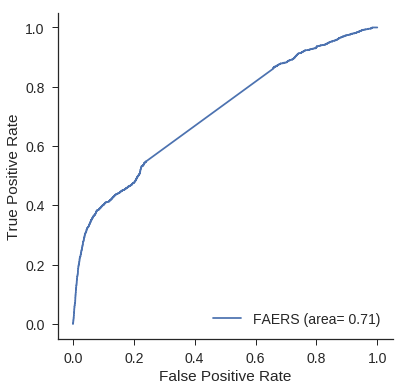

In [131]:
scores = score(features_weight, X_test_reduced)
print len(scores)
print scores[0]

threshold = 5
predictions = predict_ddi(scores, threshold)

In [92]:
# Loop to test all three models
# We use a Logistic Regression Binary classifier: each drug or drug pair is represented by a combination of AEs and their weight (beta coefficient)
# If a drug is above a certain threshold, we classify it as causing hypertension

alphas_selected = [0.0001, 0.0002, 0.0003]
threshold = 4

for alpha in alphas_selected:
    print alpha
    
    #Extraction of features
    features_indice = list()
    features_weight = list()
    features = list()

    for i in range (len(coef_lasso[2+alphas_selected.index(alpha)])):
        if coef_lasso[2+alphas_selected.index(alpha)][i] != 0.:
            features_indice.append(i)

    for i in range (len(all_pairoutcomes)):
        if i in features_indice:
            features.append(all_pairoutcomes[i])
            features_weight.append((all_pairoutcomes[i], coef_lasso[2+alphas_selected.index(alpha)][i]))
    
    print len(features)
    
    #Construction of the new testing frequency table
    X_test_reduced = make_lsd_testing_table_reduced(features)
    print X_test_reduced.shape
    
    #Fingerprint construction
    scores = score(features_weight, X_test_reduced)
    predictions = predict_ddi(scores, threshold)


  1%|          | 7768/1313184 [00:00<00:16, 77657.30it/s]

0.0001
24


  7%|▋         | 88386/1313184 [00:08<03:02, 6719.57it/s] 


KeyboardInterrupt: 

In [62]:
# Random Forest Classifier after the L1 reduction of features

def drugpair_predictions_rf_reduced(X, y, X_test):
    
    # can't use oob after L1 regularization
    rf = RandomForestClassifier(n_estimators = 100, oob_score=False, random_state=12)
    rf.fit(X,y) #Build a forest of trees from the training set (X, y).
    
    predictions_proba = rf.predict_proba(X_test)[:,1]
    predictions = rf.predict(X_test) #predict class for X_test
    print "Mean accuracy on the given test data and labels: ", rf.score(X,y)  
    
    y_pred_Faers = y_pred_FAERS(drug_mapping)
    #y_pred_VA = y_pred_va()
    
    predicted_ddi = sorted(zip(predictions_proba, all_drugpairs))
    predicted_ddi.reverse()
    i=0
    while predicted_ddi[i][0]>0.5:
        i+=1
    predicted_ddi = predicted_ddi[:i]
            
    #(i.e with at least one drug known to have hypertension as a side effect)
    print "Number of positive predictions:",np.sum(y_pred_Faers)
    
    print "FAERS drugpairs ROC:",roc_auc_score(y_true=y_pred_Faers,y_score=predictions_proba)
    fprFA, tprFA, _ = roc_curve(y_true=y_pred_Faers,y_score=predictions_proba)
    
    #print "VA drugpairs ROC:",roc_auc_score(y_true=y_pred_VA,y_score=predictions_proba)
    #fprVA, tprVA, _ = roc_curve(y_true=y_pred_VA,y_score=predictions_proba)

    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprFA,tprFA,label='FAERS (area= %0.2f)' % auc(fprFA,tprFA))
    #plt.plot(fprVA,tprVA,label='VA (area= %0.2f)' % auc(fprVA,tprVA))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return predicted_ddi

Mean accuracy on the given test data and labels:  0.980392156863
Number of positive predictions: 2744.0
FAERS drugpairs ROC: 0.645712406909
7488


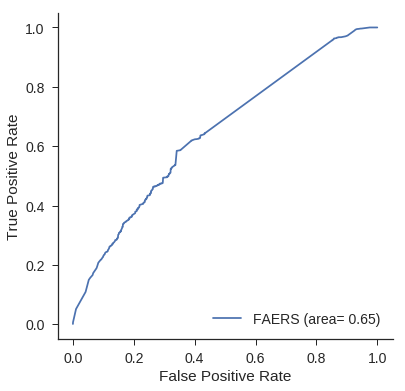

In [132]:
predicted_ddi = drugpair_predictions_rf_reduced(X_reduced,y_reduced,X_test_reduced)
print len(predicted_ddi)

In [66]:
# SVM method after L1 regularization of features
def drugpair_predictions_svm(X,y,X_test):
    
    clf = svm.SVC(probability=True)
    #clf = svm.SVC()
    clf.fit(X,y)
    
    predictions_proba = clf.predict_proba(X_test)[:,1]
    #predictions_proba = clf.decision_function(X_test)
    predictions = clf.predict(X_test) #predict class for X_test
    print "Mean accuracy on the given test data and labels: ", clf.score(X,y)  
    
    y_pred_Faers = y_pred_FAERS(drug_mapping)
    #y_pred_VA = y_pred_va()
    
    predicted_ddi = sorted(zip(predictions_proba, all_drugpairs))
    predicted_ddi.reverse()
    i=0
    while predicted_ddi[i][0]>0.5:
        i+=1
    predicted_ddi = predicted_ddi[:i]
            
    #(i.e with at least one drug known to have hypertension as a side effect)
    print "Number of positive predictions:",np.sum(y_pred_Faers)
    
    print "FAERS drugpairs ROC:",roc_auc_score(y_true=y_pred_Faers,y_score=predictions_proba)
    fprFA, tprFA, _ = roc_curve(y_true=y_pred_Faers,y_score=predictions_proba)
    
    #print "VA drugpairs ROC:",roc_auc_score(y_true=y_pred_VA,y_score=predictions_proba)
    #fprVA, tprVA, _ = roc_curve(y_true=y_pred_VA,y_score=predictions_proba)

    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprFA,tprFA,label='FAERS (area= %0.2f)' % auc(fprFA,tprFA))
    #plt.plot(fprVA,tprVA,label='VA (area= %0.2f)' % auc(fprVA,tprVA))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return predicted_ddi

Mean accuracy on the given test data and labels:  0.666666666667
Number of positive predictions: 2744.0
FAERS drugpairs ROC: 0.652858218371
19848


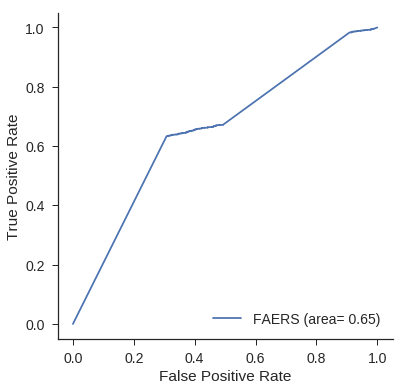

In [133]:
predicted_ddi = drugpair_predictions_svm(X_reduced,y_reduced,X_test_reduced)
print len(predicted_ddi)

In [68]:
# Prediction without features reduction
def drugpair_predictions_rf(X,y,X_test):  
    
    rf = RandomForestClassifier(n_estimators = 100, oob_score=True, random_state=12)
    rf.fit(X,y) #Build a forest of trees from the training set (X, y).
    
    print "Number of estimators: ", len(rf.estimators_)
    
    predictions_proba = rf.predict_proba(X_test)[:,1]
    predictions = rf.predict(X_test) #predict class for X_test
    print "Mean accuracy on the given test data and labels: ", rf.score(X,y)   

    oob_predictions = rf.oob_decision_function_[:,1]
    oob_predictions[ np.where( np.isnan(oob_predictions) == True)[0]] = 0
    
    #roc_auc_score computes the area under the ROC curve
    print "OOB ROC:",roc_auc_score(y_true=y, y_score=oob_predictions)
    fprOOB, tprOOB, _ = roc_curve(y_true=y,y_score=oob_predictions)
    
    y_pred_Faers = y_pred_FAERS(drug_mapping)
    #y_pred_VA = y_pred_va()
    
    predicted_ddi = sorted(zip(predictions_proba, all_drugpairs))
    predicted_ddi.reverse()
    i=0
    while predicted_ddi[i][0]>0.5:
        i+=1
    predicted_ddi = predicted_ddi[:i]
            
    #(i.e with at least one drug known to have hypertension as a side effect)
    print "Number of positive predictions FAERS:",np.sum(y_pred_Faers)
    print "Number of ddi predictions (with a probability > 0,5): ", len(predicted_ddi)
    
    print "FAERS drugpairs ROC:",roc_auc_score(y_true=y_pred_Faers,y_score=predictions_proba)
    fprFA, tprFA, _ = roc_curve(y_true=y_pred_Faers,y_score=predictions_proba)
    
    #print "VA drugpairs ROC:",roc_auc_score(y_true=y_pred_VA,y_score=predictions_proba)
    #fprVA, tprVA, _ = roc_curve(y_true=y_pred_VA,y_score=predictions_proba)
    
    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprOOB,tprOOB,label='OOB (area= %0.2f)' % auc(fprOOB,tprOOB))
    plt.plot(fprFA,tprFA,label='FAERS (area= %0.2f)' % auc(fprFA,tprFA))
    #plt.plot(fprVA,tprVA,label='VA (area= %0.2f)' % auc(fprVA,tprVA))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return predicted_ddi

Number of estimators:  100
Mean accuracy on the given test data and labels:  0.980392156863
OOB ROC: 0.882352941176
Number of positive predictions FAERS: 2744.0
Number of ddi predictions (with a probability > 0,5):  6386
FAERS drugpairs ROC: 0.59556076895


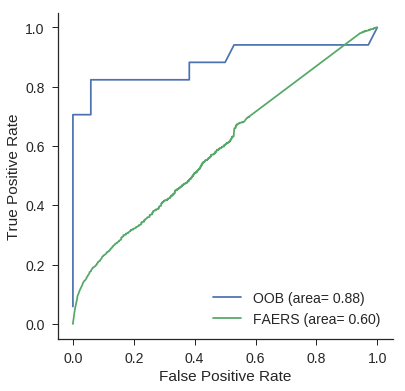

In [134]:
pred_ddi = drugpair_predictions_rf(X,y,X_test)

## DDI predictions

In [51]:
#Treatment of the predictions
final_predictions = list()

pos_drugs_mapped = list()
for pos_drug in pos_controls:
    if pos_drug not in drug_mapping:
        continue
        
    pos_drugs_mapped.append(drug_mapping[pos_drug])

# Removing the pairs where at least one of the drugs is known to be responsible for hypertension alone
for prob, drugpair in predicted_ddi:
    if (drugpair[0] not in pos_drugs_mapped):
        if (drugpair[1] not in pos_drugs_mapped):
            # All drugpairs are twice in the list ((a,b) and (b,a)), we only keep one
            if drugpair[0] > drugpair[1]:
                final_predictions.append(drugpair)

print len(predicted_ddi)
print len(final_predictions)                
top_ddi = final_predictions[:200]
#print top_ddi

14008
2239


In [50]:
# Pull the top prediction
pair = top_ddi[0]
pair2 = top_ddi[1]
#pair3 = top_ddi[2]
#pair4 = top_ddi[3]
print pair
print pair2
print concept2name[pair[0]], concept2name[pair[1]]
print concept2name[pair2[0]], concept2name[pair2[1]]
#print concept2name[pair3[0]], concept2name[pair3[1]]
#print concept2name[pair4[0]], concept2name[pair4[1]]


(19035704, 1341927)
(19135832, 1551860)
Calcium Carbonate Enalapril
Multivitamin preparation Pravastatin


## Corroborate drugpair predictions using OHDSI data
Analysis of the top predicted DDIs.
Method: Creation of cohorts of patients using the OHDSI API.
Criteria: Patients exposed to either drug of a predicted drugpair alone and patients exposed to both within a 7 days interval.
All patients must have had their blood pressure measured within 30 days of their last drug intake (before and after). 

In [68]:
map_id_name, map_name_id = ohdsi.mapping()

In [69]:
# Retrieve patient information for the top 50 ddi predictions
qualifying_drugpairs = list()

for drugpair in tqdm(top_ddi):
    
    # Creation of the first cohort with exposure to both drugs of the drugpair within 7 days
    concept1 = ohdsi.get_concept_info(drugpair[0])
    concept2 = ohdsi.get_concept_info(drugpair[1])
    
    data = ohdsi.cohort_definition_2D(concept1, concept2)
    status = ohdsi.create_cohort(data)
    
    # Update the mapping dicionaries
    cohorts = ohdsi.get_cohorts()
    for cohort in cohorts:
        if cohort['name'] == "%s_%s"%(concept1["CONCEPT_NAME"],concept2["CONCEPT_NAME"]):
            map_id_name[cohort['id']] =  cohort['name']
            map_name_id[cohort['name']] = cohort['id']
    
    cohort_id = map_name_id["%s_%s"%(concept1["CONCEPT_NAME"],concept2["CONCEPT_NAME"])]
    info = ohdsi.generate_cohort(cohort_id)
    
    patients = ohdsi.getAlldistinctPatients(cohort_id)
    print len(patients)
    
    if(len(patients)<30):
        print "Not enough patients for cohort %s_%s" %(concept1["CONCEPT_NAME"],concept2["CONCEPT_NAME"])
        status_delete = ohdsi.delete_cohort(cohort_id)
    else:
        print "Enough patients for cohort %s_%s" %(concept1["CONCEPT_NAME"],concept2["CONCEPT_NAME"])
        qualifying_drugpairs.append(drugpair)

  0%|          | 0/200 [00:00<?, ?it/s]

A cohort with the same name already exists, please choose another name


  0%|          | 1/200 [00:03<10:10,  3.07s/it]

91
Enough patients for cohort Calcium Carbonate_Enalapril
A cohort with the same name already exists, please choose another name


  1%|          | 2/200 [00:06<10:52,  3.30s/it]

0
Not enough patients for cohort Multivitamin preparation_Pravastatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  2%|▏         | 3/200 [00:10<11:01,  3.36s/it]

0
Not enough patients for cohort Multivitamin preparation_Estrogens, Conjugated (USP)
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  2%|▏         | 4/200 [00:13<10:42,  3.28s/it]

6
Not enough patients for cohort Vitamin D_Simvastatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  2%|▎         | 5/200 [00:17<11:18,  3.48s/it]

5
Not enough patients for cohort Vitamin D_Amlodipine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  3%|▎         | 6/200 [00:20<11:13,  3.47s/it]

4
Not enough patients for cohort Vitamin D_Lisinopril
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  4%|▎         | 7/200 [00:23<10:32,  3.28s/it]

3
Not enough patients for cohort Vitamin D_Albuterol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  4%|▍         | 8/200 [00:26<10:02,  3.14s/it]

132
Enough patients for cohort atorvastatin_Alprazolam
A cohort with the same name already exists, please choose another name


  4%|▍         | 9/200 [00:30<10:25,  3.28s/it]

292
Enough patients for cohort rosuvastatin_Lisinopril
A cohort with the same name already exists, please choose another name


  5%|▌         | 10/200 [00:33<10:11,  3.22s/it]

1
Not enough patients for cohort Folic Acid_infliximab
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  6%|▌         | 11/200 [00:37<10:47,  3.43s/it]

0
Not enough patients for cohort Calcium_Lisinopril
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  6%|▌         | 12/200 [00:41<11:39,  3.72s/it]

13
Not enough patients for cohort Ascorbic Acid_Enalapril
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  6%|▋         | 13/200 [00:44<10:55,  3.51s/it]

7
Not enough patients for cohort Vitamin A_levothyroxine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  7%|▋         | 14/200 [00:47<10:37,  3.43s/it]

2
Not enough patients for cohort Vitamin A_Lisinopril
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  8%|▊         | 15/200 [00:50<09:52,  3.20s/it]

111
Enough patients for cohort Alendronate_Aspirin
A cohort with the same name already exists, please choose another name


  8%|▊         | 16/200 [00:54<10:45,  3.51s/it]

1
Not enough patients for cohort Alendronate_tiotropium
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  8%|▊         | 17/200 [00:57<10:15,  3.36s/it]

363
Enough patients for cohort Pravastatin_Aspirin
A cohort with the same name already exists, please choose another name


  9%|▉         | 18/200 [01:01<10:13,  3.37s/it]

286
Enough patients for cohort Estrogens, Conjugated (USP)_levothyroxine
A cohort with the same name already exists, please choose another name


 10%|▉         | 19/200 [01:04<10:23,  3.45s/it]

1041
Enough patients for cohort atorvastatin_Simvastatin
A cohort with the same name already exists, please choose another name


 10%|█         | 20/200 [01:09<11:12,  3.73s/it]

392
Enough patients for cohort Simvastatin_Digoxin
A cohort with the same name already exists, please choose another name


 10%|█         | 21/200 [01:12<10:43,  3.59s/it]

726
Enough patients for cohort Simvastatin_Hydrocodone
A cohort with the same name already exists, please choose another name


 11%|█         | 22/200 [01:16<10:48,  3.64s/it]

171
Enough patients for cohort Simvastatin_Esomeprazole
A cohort with the same name already exists, please choose another name


 12%|█▏        | 23/200 [01:19<10:03,  3.41s/it]

152
Enough patients for cohort Simvastatin_Diazepam
A cohort with the same name already exists, please choose another name


 12%|█▏        | 24/200 [01:22<10:05,  3.44s/it]

183
Enough patients for cohort ezetimibe_Metoprolol
A cohort with the same name already exists, please choose another name


 12%|█▎        | 25/200 [01:25<09:49,  3.37s/it]

169
Enough patients for cohort ezetimibe_Aspirin
A cohort with the same name already exists, please choose another name


 13%|█▎        | 26/200 [01:29<09:57,  3.44s/it]

11
Not enough patients for cohort Teriparatide_Ranitidine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 14%|█▎        | 27/200 [01:32<09:48,  3.40s/it]

233
Enough patients for cohort levothyroxine_Ranitidine
A cohort with the same name already exists, please choose another name


 14%|█▍        | 28/200 [01:36<10:11,  3.55s/it]

161
Enough patients for cohort Clonidine_Aspirin
A cohort with the same name already exists, please choose another name


 14%|█▍        | 29/200 [01:39<09:46,  3.43s/it]

176
Enough patients for cohort Losartan_Aspirin
A cohort with the same name already exists, please choose another name


 15%|█▌        | 30/200 [01:43<09:46,  3.45s/it]

185
Enough patients for cohort Ramipril_Aspirin
A cohort with the same name already exists, please choose another name


 16%|█▌        | 31/200 [01:46<09:43,  3.45s/it]

745
Enough patients for cohort Amlodipine_Lisinopril
A cohort with the same name already exists, please choose another name


 16%|█▌        | 32/200 [01:50<10:05,  3.60s/it]

114
Enough patients for cohort Amlodipine_Esomeprazole
A cohort with the same name already exists, please choose another name


 16%|█▋        | 33/200 [01:53<09:32,  3.43s/it]

144
Enough patients for cohort Lisinopril_Clonazepam
A cohort with the same name already exists, please choose another name


 17%|█▋        | 34/200 [01:57<09:36,  3.47s/it]

32
Enough patients for cohort Lisinopril_Escitalopram
A cohort with the same name already exists, please choose another name


 18%|█▊        | 35/200 [02:00<09:36,  3.50s/it]

89
Enough patients for cohort Metoprolol_Clonazepam
A cohort with the same name already exists, please choose another name


 18%|█▊        | 36/200 [02:04<09:27,  3.46s/it]

46
Enough patients for cohort Metoprolol_duloxetine
A cohort with the same name already exists, please choose another name


 18%|█▊        | 37/200 [02:08<09:55,  3.65s/it]

148
Enough patients for cohort Hydrocodone_Clonazepam
A cohort with the same name already exists, please choose another name


 19%|█▉        | 38/200 [02:11<09:51,  3.65s/it]

151
Enough patients for cohort Hydrocodone_Diazepam
A cohort with the same name already exists, please choose another name


 20%|█▉        | 39/200 [02:14<09:14,  3.44s/it]

13
Not enough patients for cohort Esomeprazole_Escitalopram
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 20%|██        | 40/200 [02:18<09:10,  3.44s/it]

0
Not enough patients for cohort telaprevir_levothyroxine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 20%|██        | 41/200 [02:21<09:17,  3.50s/it]

0
Not enough patients for cohort Insulin_Amlodipine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 21%|██        | 42/200 [02:25<09:21,  3.56s/it]

0
Not enough patients for cohort Folic Acid_Calcium
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 22%|██▏       | 43/200 [02:28<09:10,  3.51s/it]

2
Not enough patients for cohort Folic Acid_Vitamin D
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 22%|██▏       | 44/200 [02:32<08:55,  3.44s/it]

2
Not enough patients for cohort peginterferon alfa-2a_levothyroxine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 22%|██▎       | 45/200 [02:35<08:55,  3.45s/it]

46
Enough patients for cohort Alendronate_Ramipril
A cohort with the same name already exists, please choose another name


 23%|██▎       | 46/200 [02:39<08:54,  3.47s/it]

206
Enough patients for cohort Simvastatin_Nitroglycerin
A cohort with the same name already exists, please choose another name


 24%|██▎       | 47/200 [02:42<09:01,  3.54s/it]

173
Enough patients for cohort Clonidine_Amlodipine
A cohort with the same name already exists, please choose another name


 24%|██▍       | 48/200 [02:46<09:10,  3.62s/it]

183
Enough patients for cohort Clonidine_Metoprolol
A cohort with the same name already exists, please choose another name


 24%|██▍       | 49/200 [02:50<09:06,  3.62s/it]

339
Enough patients for cohort Nitroglycerin_Lisinopril
A cohort with the same name already exists, please choose another name


 25%|██▌       | 50/200 [02:53<08:35,  3.44s/it]

231
Enough patients for cohort Nitroglycerin_Furosemide
A cohort with the same name already exists, please choose another name


 26%|██▌       | 51/200 [02:56<08:26,  3.40s/it]

205
Enough patients for cohort Metoprolol_Ranitidine
A cohort with the same name already exists, please choose another name


 26%|██▌       | 52/200 [03:00<08:34,  3.48s/it]

4
Not enough patients for cohort Methotrexate_infliximab
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 26%|██▋       | 53/200 [03:03<08:29,  3.47s/it]

102
Enough patients for cohort Albuterol_Esomeprazole
A cohort with the same name already exists, please choose another name


 27%|██▋       | 54/200 [03:07<08:23,  3.45s/it]

233
Enough patients for cohort olmesartan_Aspirin
A cohort with the same name already exists, please choose another name


 28%|██▊       | 55/200 [03:11<08:48,  3.64s/it]

0
Not enough patients for cohort Multivitamin preparation_Digoxin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 28%|██▊       | 56/200 [03:14<08:21,  3.49s/it]

0
Not enough patients for cohort Multivitamin preparation_Lisinopril
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 28%|██▊       | 57/200 [03:17<08:10,  3.43s/it]

0
Not enough patients for cohort Multivitamin preparation_Metoprolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 29%|██▉       | 58/200 [03:21<08:17,  3.50s/it]

0
Not enough patients for cohort Multivitamin preparation_Methotrexate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 30%|██▉       | 59/200 [03:25<08:24,  3.58s/it]

0
Not enough patients for cohort Multivitamin preparation_Hydrocodone
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 30%|███       | 60/200 [03:29<08:39,  3.71s/it]

0
Not enough patients for cohort Multivitamin preparation_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 30%|███       | 61/200 [03:33<08:44,  3.77s/it]

31
Enough patients for cohort Folic Acid_atorvastatin
A cohort with the same name already exists, please choose another name


 31%|███       | 62/200 [03:36<08:10,  3.55s/it]

99
Enough patients for cohort Folic Acid_levothyroxine
A cohort with the same name already exists, please choose another name


 32%|███▏      | 63/200 [03:39<08:11,  3.59s/it]

33
Enough patients for cohort Folic Acid_Amlodipine
A cohort with the same name already exists, please choose another name


 32%|███▏      | 64/200 [03:42<07:41,  3.39s/it]

12
Not enough patients for cohort Folic Acid_Esomeprazole
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 32%|███▎      | 65/200 [03:45<07:28,  3.32s/it]

12
Not enough patients for cohort Folic Acid_Alprazolam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 33%|███▎      | 66/200 [03:49<07:49,  3.51s/it]

115
Enough patients for cohort Calcium Carbonate_Aspirin
A cohort with the same name already exists, please choose another name


 34%|███▎      | 67/200 [03:53<07:39,  3.45s/it]

0
Not enough patients for cohort Calcium_Vitamin D
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 34%|███▍      | 68/200 [03:56<07:42,  3.50s/it]

0
Not enough patients for cohort Calcium_Simvastatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 34%|███▍      | 69/200 [03:59<07:24,  3.39s/it]

0
Not enough patients for cohort Calcium_Metoprolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 35%|███▌      | 70/200 [04:03<07:26,  3.43s/it]

0
Not enough patients for cohort Calcium_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 36%|███▌      | 71/200 [04:07<07:49,  3.64s/it]

21
Not enough patients for cohort Ascorbic Acid_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 36%|███▌      | 72/200 [04:10<07:23,  3.47s/it]

7
Not enough patients for cohort Vitamin D_levothyroxine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 36%|███▋      | 73/200 [04:13<07:12,  3.41s/it]

7
Not enough patients for cohort Vitamin D_Metoprolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 37%|███▋      | 74/200 [04:17<07:19,  3.49s/it]

1061
Enough patients for cohort atorvastatin_levothyroxine
A cohort with the same name already exists, please choose another name


 38%|███▊      | 75/200 [04:21<07:23,  3.55s/it]

613
Enough patients for cohort atorvastatin_Hydrocodone
A cohort with the same name already exists, please choose another name


 38%|███▊      | 76/200 [04:24<07:14,  3.51s/it]

36
Enough patients for cohort atorvastatin_duloxetine
A cohort with the same name already exists, please choose another name


 38%|███▊      | 77/200 [04:28<07:05,  3.46s/it]

615
Enough patients for cohort levothyroxine_Metoprolol
A cohort with the same name already exists, please choose another name


 39%|███▉      | 78/200 [04:31<07:04,  3.48s/it]

749
Enough patients for cohort levothyroxine_Hydrocodone
A cohort with the same name already exists, please choose another name


 40%|███▉      | 79/200 [04:35<07:17,  3.62s/it]

192
Enough patients for cohort levothyroxine_Alprazolam
A cohort with the same name already exists, please choose another name


 40%|████      | 80/200 [04:38<06:49,  3.41s/it]

36
Enough patients for cohort Paclitaxel_Hydrocodone
A cohort with the same name already exists, please choose another name


 40%|████      | 81/200 [04:46<09:44,  4.91s/it]

287
Enough patients for cohort valsartan_Aspirin
A cohort with the same name already exists, please choose another name


 41%|████      | 82/200 [04:49<08:27,  4.30s/it]

371
Enough patients for cohort Lisinopril_Albuterol
A cohort with the same name already exists, please choose another name


 42%|████▏     | 83/200 [04:52<07:45,  3.98s/it]

326
Enough patients for cohort Metoprolol_Albuterol
A cohort with the same name already exists, please choose another name


 42%|████▏     | 84/200 [04:56<07:22,  3.82s/it]

384
Enough patients for cohort Hydrocodone_Albuterol
A cohort with the same name already exists, please choose another name


 42%|████▎     | 85/200 [04:59<06:38,  3.47s/it]

572
Enough patients for cohort Hydrocodone_Aspirin
A cohort with the same name already exists, please choose another name


 43%|████▎     | 86/200 [05:02<06:32,  3.45s/it]

579
Enough patients for cohort Hydrocodone_Furosemide
A cohort with the same name already exists, please choose another name


 44%|████▎     | 87/200 [05:05<06:29,  3.45s/it]

3
Not enough patients for cohort Albuterol_tiotropium
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 44%|████▍     | 88/200 [05:09<06:30,  3.49s/it]

96
Enough patients for cohort Albuterol_Clonazepam
A cohort with the same name already exists, please choose another name


 44%|████▍     | 89/200 [05:12<06:28,  3.50s/it]

36
Enough patients for cohort Aspirin_Escitalopram
A cohort with the same name already exists, please choose another name


 45%|████▌     | 90/200 [05:16<06:22,  3.48s/it]

0
Not enough patients for cohort Multivitamin preparation_Calcium Carbonate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 46%|████▌     | 91/200 [05:19<06:19,  3.48s/it]

0
Not enough patients for cohort Multivitamin preparation_Ascorbic Acid
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 46%|████▌     | 92/200 [05:23<06:23,  3.55s/it]

0
Not enough patients for cohort Multivitamin preparation_Alendronate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 46%|████▋     | 93/200 [05:27<06:27,  3.63s/it]

0
Not enough patients for cohort Multivitamin preparation_atorvastatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 47%|████▋     | 94/200 [05:31<06:32,  3.70s/it]

0
Not enough patients for cohort Multivitamin preparation_Simvastatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 48%|████▊     | 95/200 [05:35<06:54,  3.95s/it]

0
Not enough patients for cohort Multivitamin preparation_levothyroxine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 48%|████▊     | 96/200 [05:41<07:30,  4.33s/it]

0
Not enough patients for cohort Multivitamin preparation_Albuterol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 48%|████▊     | 97/200 [05:44<07:01,  4.09s/it]

0
Not enough patients for cohort Multivitamin preparation_Diphenhydramine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 49%|████▉     | 98/200 [05:48<06:39,  3.92s/it]

0
Not enough patients for cohort Multivitamin preparation_Alprazolam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 50%|████▉     | 99/200 [05:51<06:21,  3.78s/it]

0
Not enough patients for cohort Multivitamin preparation_Diazepam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 50%|█████     | 100/200 [05:54<06:07,  3.68s/it]

0
Not enough patients for cohort Insulin_Simvastatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 50%|█████     | 101/200 [05:59<06:17,  3.81s/it]

0
Not enough patients for cohort Insulin_Metoprolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 51%|█████     | 102/200 [06:02<05:47,  3.54s/it]

0
Not enough patients for cohort Folic Acid_Simvastatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 52%|█████▏    | 103/200 [06:06<06:08,  3.80s/it]

0
Not enough patients for cohort Folic Acid_Lisinopril
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 52%|█████▏    | 104/200 [06:09<05:39,  3.53s/it]

0
Not enough patients for cohort Folic Acid_Hydrocodone
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 52%|█████▎    | 105/200 [06:12<05:33,  3.51s/it]

0
Not enough patients for cohort Folic Acid_Albuterol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 53%|█████▎    | 106/200 [06:16<05:23,  3.44s/it]

0
Not enough patients for cohort Folic Acid_Diazepam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 54%|█████▎    | 107/200 [06:19<05:23,  3.48s/it]

0
Not enough patients for cohort Potassium Chloride_Lisinopril
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 54%|█████▍    | 108/200 [06:23<05:24,  3.53s/it]

0
Not enough patients for cohort Potassium Chloride_Metoprolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 55%|█████▍    | 109/200 [06:26<05:25,  3.57s/it]

0
Not enough patients for cohort Potassium Chloride_Hydrocodone
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 55%|█████▌    | 110/200 [06:30<05:11,  3.46s/it]

0
Not enough patients for cohort Potassium Chloride_Albuterol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 56%|█████▌    | 111/200 [06:33<05:06,  3.44s/it]

0
Not enough patients for cohort Potassium Chloride_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 56%|█████▌    | 112/200 [06:37<05:07,  3.49s/it]

0
Not enough patients for cohort Calcium_levothyroxine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 56%|█████▋    | 113/200 [06:45<07:09,  4.94s/it]

0
Not enough patients for cohort Vitamin A_Simvastatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 57%|█████▋    | 114/200 [06:48<06:12,  4.33s/it]

0
Not enough patients for cohort Insulin Lispro_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 57%|█████▊    | 115/200 [06:51<05:45,  4.06s/it]

0
Not enough patients for cohort atorvastatin_Amlodipine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 58%|█████▊    | 116/200 [06:55<05:31,  3.94s/it]

0
Not enough patients for cohort atorvastatin_Warfarin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 58%|█████▊    | 117/200 [06:58<05:08,  3.72s/it]

0
Not enough patients for cohort atorvastatin_Lisinopril
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 59%|█████▉    | 118/200 [07:01<04:48,  3.52s/it]

0
Not enough patients for cohort atorvastatin_Metoprolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 60%|█████▉    | 119/200 [07:04<04:32,  3.37s/it]

0
Not enough patients for cohort atorvastatin_Albuterol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 60%|██████    | 120/200 [07:08<04:29,  3.37s/it]

0
Not enough patients for cohort atorvastatin_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 60%|██████    | 121/200 [07:11<04:28,  3.40s/it]

0
Not enough patients for cohort Simvastatin_levothyroxine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 61%|██████    | 122/200 [07:15<04:25,  3.41s/it]

0
Not enough patients for cohort Simvastatin_Amlodipine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 62%|██████▏   | 123/200 [07:18<04:30,  3.52s/it]

0
Not enough patients for cohort Simvastatin_Warfarin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 62%|██████▏   | 124/200 [07:22<04:40,  3.69s/it]

0
Not enough patients for cohort Simvastatin_Lisinopril
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 62%|██████▎   | 125/200 [07:25<04:22,  3.50s/it]

0
Not enough patients for cohort Simvastatin_Metoprolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 63%|██████▎   | 126/200 [07:29<04:13,  3.42s/it]

0
Not enough patients for cohort Simvastatin_Albuterol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 64%|██████▎   | 127/200 [07:32<04:06,  3.38s/it]

0
Not enough patients for cohort Simvastatin_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 64%|██████▍   | 128/200 [07:36<04:07,  3.44s/it]

0
Not enough patients for cohort Simvastatin_Furosemide
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 64%|██████▍   | 129/200 [07:39<04:03,  3.43s/it]

0
Not enough patients for cohort ezetimibe_levothyroxine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 65%|██████▌   | 130/200 [07:43<04:11,  3.60s/it]

0
Not enough patients for cohort rosuvastatin_Metoprolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 66%|██████▌   | 131/200 [07:46<03:56,  3.43s/it]

0
Not enough patients for cohort rosuvastatin_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 66%|██████▌   | 132/200 [07:50<03:56,  3.47s/it]

0
Not enough patients for cohort levothyroxine_Amlodipine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 66%|██████▋   | 133/200 [07:53<03:51,  3.46s/it]

0
Not enough patients for cohort levothyroxine_Diltiazem
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 67%|██████▋   | 134/200 [07:56<03:48,  3.46s/it]

0
Not enough patients for cohort levothyroxine_Lisinopril
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 68%|██████▊   | 135/200 [08:01<03:59,  3.68s/it]

0
Not enough patients for cohort levothyroxine_Albuterol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 68%|██████▊   | 136/200 [08:04<03:55,  3.68s/it]

0
Not enough patients for cohort levothyroxine_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 68%|██████▊   | 137/200 [08:07<03:35,  3.42s/it]

0
Not enough patients for cohort levothyroxine_Furosemide
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 69%|██████▉   | 138/200 [08:11<03:33,  3.45s/it]

0
Not enough patients for cohort levothyroxine_Clonazepam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 70%|██████▉   | 139/200 [08:14<03:28,  3.42s/it]

0
Not enough patients for cohort levothyroxine_Diazepam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 70%|███████   | 140/200 [08:18<03:27,  3.45s/it]

0
Not enough patients for cohort levothyroxine_duloxetine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 70%|███████   | 141/200 [08:21<03:22,  3.44s/it]

0
Not enough patients for cohort carvedilol_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 71%|███████   | 142/200 [08:25<03:32,  3.66s/it]

0
Not enough patients for cohort Amlodipine_Warfarin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 72%|███████▏  | 143/200 [08:29<03:26,  3.63s/it]

0
Not enough patients for cohort Amlodipine_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 72%|███████▏  | 144/200 [08:33<03:28,  3.72s/it]

0
Not enough patients for cohort Diltiazem_Metoprolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 72%|███████▎  | 145/200 [08:36<03:20,  3.64s/it]

0
Not enough patients for cohort erlotinib_Ondansetron
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 73%|███████▎  | 146/200 [08:39<03:08,  3.49s/it]

0
Not enough patients for cohort Warfarin_Hydrocodone
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 74%|███████▎  | 147/200 [08:42<02:57,  3.35s/it]

0
Not enough patients for cohort Warfarin_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 74%|███████▍  | 148/200 [08:47<03:23,  3.91s/it]

0
Not enough patients for cohort Lisinopril_Metoprolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 74%|███████▍  | 149/200 [08:51<03:19,  3.90s/it]

0
Not enough patients for cohort Lisinopril_Hydrocodone
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 75%|███████▌  | 150/200 [08:55<03:13,  3.87s/it]

0
Not enough patients for cohort Lisinopril_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 76%|███████▌  | 151/200 [08:58<02:57,  3.63s/it]

0
Not enough patients for cohort Lisinopril_Esomeprazole
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 76%|███████▌  | 152/200 [09:02<02:52,  3.60s/it]

0
Not enough patients for cohort Metoprolol_Hydrocodone
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 76%|███████▋  | 153/200 [09:04<02:35,  3.30s/it]

0
Not enough patients for cohort Metoprolol_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 77%|███████▋  | 154/200 [09:08<02:36,  3.41s/it]

0
Not enough patients for cohort Metoprolol_Esomeprazole
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 78%|███████▊  | 155/200 [09:11<02:27,  3.28s/it]

0
Not enough patients for cohort Metoprolol_Alprazolam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 78%|███████▊  | 156/200 [09:15<02:28,  3.39s/it]

0
Not enough patients for cohort Metoprolol_Escitalopram
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 78%|███████▊  | 157/200 [09:18<02:24,  3.36s/it]

0
Not enough patients for cohort Hydrocodone_Esomeprazole
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 79%|███████▉  | 158/200 [09:21<02:21,  3.38s/it]

0
Not enough patients for cohort Albuterol_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 80%|███████▉  | 159/200 [09:25<02:22,  3.48s/it]

0
Not enough patients for cohort Albuterol_Diazepam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 80%|████████  | 160/200 [09:29<02:23,  3.59s/it]

0
Not enough patients for cohort Aspirin_tiotropium
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 80%|████████  | 161/200 [09:32<02:12,  3.40s/it]

0
Not enough patients for cohort Aspirin_Docusate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 81%|████████  | 162/200 [09:35<02:11,  3.45s/it]

0
Not enough patients for cohort Aspirin_tamsulosin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 82%|████████▏ | 163/200 [09:40<02:15,  3.66s/it]

0
Not enough patients for cohort Aspirin_Clonazepam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 82%|████████▏ | 164/200 [09:43<02:08,  3.56s/it]

0
Not enough patients for cohort Aspirin_Alprazolam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 82%|████████▎ | 165/200 [09:46<01:59,  3.42s/it]

0
Not enough patients for cohort Aspirin_Diazepam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 83%|████████▎ | 166/200 [09:49<01:55,  3.40s/it]

0
Not enough patients for cohort Furosemide_Esomeprazole
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 84%|████████▎ | 167/200 [09:53<01:58,  3.60s/it]

0
Not enough patients for cohort Furosemide_Alprazolam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 84%|████████▍ | 168/200 [09:56<01:47,  3.37s/it]

0
Not enough patients for cohort Esomeprazole_Clonazepam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 84%|████████▍ | 169/200 [10:00<01:47,  3.47s/it]

0
Not enough patients for cohort Esomeprazole_Alprazolam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 85%|████████▌ | 170/200 [10:03<01:43,  3.45s/it]

0
Not enough patients for cohort Multivitamin preparation_Potassium Chloride
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 86%|████████▌ | 171/200 [10:08<01:47,  3.70s/it]

0
Not enough patients for cohort Multivitamin preparation_Calcium
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 86%|████████▌ | 172/200 [10:11<01:36,  3.45s/it]

0
Not enough patients for cohort Multivitamin preparation_Vitamin D
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 86%|████████▋ | 173/200 [10:14<01:30,  3.35s/it]

0
Not enough patients for cohort Multivitamin preparation_rosuvastatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 87%|████████▋ | 174/200 [10:17<01:29,  3.45s/it]

0
Not enough patients for cohort Multivitamin preparation_Amlodipine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 88%|████████▊ | 175/200 [10:21<01:30,  3.64s/it]

0
Not enough patients for cohort Multivitamin preparation_Diltiazem
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 88%|████████▊ | 176/200 [10:24<01:21,  3.40s/it]

0
Not enough patients for cohort Multivitamin preparation_Warfarin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 88%|████████▊ | 177/200 [10:28<01:19,  3.44s/it]

0
Not enough patients for cohort Multivitamin preparation_valsartan
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 89%|████████▉ | 178/200 [10:31<01:17,  3.50s/it]

0
Not enough patients for cohort Multivitamin preparation_montelukast
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 90%|████████▉ | 179/200 [10:36<01:17,  3.68s/it]

0
Not enough patients for cohort Multivitamin preparation_Ranitidine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 90%|█████████ | 180/200 [10:38<01:08,  3.40s/it]

0
Not enough patients for cohort Multivitamin preparation_Furosemide
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 90%|█████████ | 181/200 [10:42<01:04,  3.40s/it]

0
Not enough patients for cohort Multivitamin preparation_Docusate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 91%|█████████ | 182/200 [10:45<01:02,  3.50s/it]

0
Not enough patients for cohort Multivitamin preparation_Esomeprazole
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 92%|█████████▏| 183/200 [10:49<01:02,  3.65s/it]

0
Not enough patients for cohort Multivitamin preparation_Escitalopram
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 92%|█████████▏| 184/200 [10:52<00:54,  3.40s/it]

0
Not enough patients for cohort Insulin_carvedilol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 92%|█████████▎| 185/200 [10:56<00:51,  3.42s/it]

0
Not enough patients for cohort Insulin_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 93%|█████████▎| 186/200 [10:59<00:48,  3.46s/it]

0
Not enough patients for cohort Insulin_Furosemide
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 94%|█████████▎| 187/200 [11:03<00:47,  3.68s/it]

0
Not enough patients for cohort Folic Acid_Alendronate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 94%|█████████▍| 188/200 [11:06<00:41,  3.48s/it]

0
Not enough patients for cohort Folic Acid_Warfarin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 94%|█████████▍| 189/200 [11:10<00:37,  3.44s/it]

0
Not enough patients for cohort Folic Acid_Metoprolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 95%|█████████▌| 190/200 [11:13<00:35,  3.52s/it]

0
Not enough patients for cohort Folic Acid_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 96%|█████████▌| 191/200 [11:17<00:32,  3.61s/it]

0
Not enough patients for cohort Folic Acid_Furosemide
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 96%|█████████▌| 192/200 [11:20<00:27,  3.39s/it]

0
Not enough patients for cohort Potassium Chloride_Simvastatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 96%|█████████▋| 193/200 [11:24<00:23,  3.41s/it]

0
Not enough patients for cohort Potassium Chloride_levothyroxine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 97%|█████████▋| 194/200 [11:27<00:20,  3.48s/it]

0
Not enough patients for cohort Potassium Chloride_carvedilol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 98%|█████████▊| 195/200 [11:31<00:17,  3.60s/it]

0
Not enough patients for cohort Potassium Chloride_Warfarin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 98%|█████████▊| 196/200 [11:34<00:13,  3.41s/it]

0
Not enough patients for cohort Potassium Chloride_Furosemide
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 98%|█████████▊| 197/200 [11:38<00:10,  3.42s/it]

0
Not enough patients for cohort Potassium Chloride_Esomeprazole
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 99%|█████████▉| 198/200 [11:41<00:07,  3.50s/it]

0
Not enough patients for cohort Calcium_atorvastatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


100%|█████████▉| 199/200 [11:45<00:03,  3.68s/it]

0
Not enough patients for cohort Vitamin D_Vitamin A
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


100%|██████████| 200/200 [11:48<00:00,  3.41s/it]

38
Enough patients for cohort Alendronate_irbesartan


In [70]:
print len(qualifying_drugpairs)
#print qualifying_drugpairs
print concept2name[qualifying_drugpairs[0][0]], concept2name[qualifying_drugpairs[0][1]]
print concept2name[qualifying_drugpairs[1][0]], concept2name[qualifying_drugpairs[1][1]]
print concept2name[qualifying_drugpairs[2][0]], concept2name[qualifying_drugpairs[2][1]]

54
Calcium Carbonate Enalapril
atorvastatin Alprazolam
rosuvastatin Lisinopril


## Corroborate drugpair predictions using clinical data

In [ ]:
#Get all patients exposed to one drug alone 
# + with blood pressure measurements within 30 days before and after the intake of drug


In [68]:
# Assess significance of the difference in values of BP for drugpair and control groups using Mann-Whitney U test
from scipy.stats import mannwhitneyu

In [69]:
# Correct for multiple hypothesis testing using Bonferroni's method